In [3]:
from L1_DifferentialEvolution import extract_data, model, diff_evolution
from scipy.optimize import Bounds
from scipy.optimize import minimize
from NelderMead_rounded import rounded_nelder_mead
from losses_bayesian import Losses
from matplotlib.animation import PillowWriter
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import math
import physics
import numpy as np
import matplotlib.pyplot as plt

frequency, intensity = extract_data() # extracting the desired information

# compressor parameters - obtained as minus the stretcher one - TO BE FIXED WITH REAL ONES ONCE THEY ARE AVAILABLE
COMPRESSOR = -1 * np.array((267.422 * 1e-24, -2.384 * 1e-36, 9.54893 * 1e-50)) # in s^2, s^3 and s^4 (SI units)
# non linearity parameter
B = 2
# cutoff frequencies, in THz, used to remove noise - derived from visual inspection
CUTOFF = (289.95, 291.91)
# model instantiation
l1_pump = model(frequency, intensity, COMPRESSOR, B, CUTOFF, num_points=int(5e3))

losses = Losses(l1_pump)

bounds_DE = Bounds(
            # GDD         # TOD          # FOD
    lb = (2.3522e-22, -1.003635e-34, 4.774465e-50),
    ub = (2.99624e-22, 9.55955e-35, 1.4323395e-49)
)

bounds_matrix = np.vstack((bounds_DE.lb, bounds_DE.ub)).T
disp_bounds = np.sort(l1_pump.translate_control(bounds_matrix, verse = "to_disp"))

In [21]:
import numpy as np

def gaussian_kernel(X1, X2, length_scale=0.8):
    """
    Gaussian kernel function for multiple parameters using NumPy.
    """
    dist = np.linalg.norm((X1[:, None] - X2) / length_scale, axis=2)
    return np.exp(-0.5 * dist**2)

def expected_improvement(X, model_mean, model_std, best_value, xi=0.01):
    """
    Expected Improvement acquisition function for multiple parameters using NumPy.
    """
    mean = model_mean(X)
    std = model_std(X)
    z = (mean - best_value - xi) / std
    return (mean - best_value - xi) * norm_cdf(z) + std * norm_pdf(z)

def norm_pdf(x):
    """
    Normal probability density function using NumPy.
    """
    return np.exp(-0.5 * x**2) / np.sqrt(2 * np.pi)

def norm_cdf(x):
    """
    Normal cumulative density function approximation using the erf approximation.
    """
    return 0.5 * (1 + erf_approx(x / np.sqrt(2)))

def erf_approx(x):
    """Approximation to the error function using a polynomial expansion."""
    # Constants for the approximation
    a1, a2, a3, a4, a5 = 0.254829592, -0.284496736, 1.421413741, -1.453152027, 1.061405429
    p = 0.3275911

    # Save the sign of x
    sign = np.sign(x)
    x = np.abs(x)

    # Approximation formula
    t = 1.0 / (1.0 + p * x)
    y = 1.0 - (((((a5 * t + a4) * t) + a3) * t + a2) * t + a1) * t * np.exp(-x**2)

    return sign * y

def gaussian_process_predict(X_train, y_train, X_test, length_scale=1.0, noise=1e-10):
    """
    Gaussian process prediction using NumPy.
    """
    # Kernel matrices
    K = gaussian_kernel(X_train, X_train, length_scale) + noise * np.eye(len(X_train))
    K_s = gaussian_kernel(X_train, X_test, length_scale)
    K_ss = gaussian_kernel(X_test, X_test, length_scale) + noise * np.eye(len(X_test))

    # Compute the inverse of K
    K_inv = np.linalg.inv(K)

    # Mean prediction
    mu_s = K_s.T @ K_inv @ y_train

    # Variance prediction
    cov_s = K_ss - K_s.T @ K_inv @ K_s
    std_s = np.sqrt(np.diag(cov_s))

    return mu_s, std_s

def bayesian_optimization(objective, bounds, n_iter=10, xi=0.02, decimal_precision1=5, decimal_precision2=6, decimal_precision3=7):
    """
    Bayesian optimization using Gaussian Processes for multiple parameters, implemented with NumPy.
    """
    noise = 0
    X = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(200, len(bounds)))
    X[:, 0] = np.round(X[:, 0], decimals=decimal_precision1) * (1 + noise * (np.random.randn(1, 200) - 0.5))
    X[:, 1] = np.round(X[:, 1], decimals=decimal_precision2) * (1 + noise * (np.random.randn(1, 200) - 0.5))
    X[:, 2] = np.round(X[:, 2], decimals=decimal_precision3) * (1 + noise * (np.random.randn(1, 200) - 0.5))
    y = np.array([objective(x) for x in X])

    for _ in range(n_iter):
        # Predict using Gaussian Process
#         mean, std = gaussian_process_predict(X, y, X, length_scale=1.0)

        # Compute the expected improvement
        new_points = np.linspace(bounds[:, 0], bounds[:, 1], num=5000)
        EI_values = expected_improvement(new_points, lambda x: gaussian_process_predict(X, y, x, length_scale=1.0)[0],
                                         lambda x: gaussian_process_predict(X, y, x, length_scale=1.0)[1], np.max(y), xi)

        # Select the next point to sample
        next_idx = np.argmax(EI_values)
        next_x = new_points[next_idx]
        next_x = next_x.flatten()

        # Sample the objective function at the next point
        next_x[0] = np.round(next_x[0], decimals=decimal_precision1) * (1 + noise * (np.random.randn(1) - 0.5))
        next_x[1] = np.round(next_x[1], decimals=decimal_precision2) * (1 + noise * (np.random.randn(1) - 0.5))
        next_x[2] = np.round(next_x[2], decimals=decimal_precision3) * (1 + noise * (np.random.randn(1) - 0.5))
        next_y = objective(next_x)

        # Update the datasets
        X = np.vstack([X, next_x])
        y = np.append(y, next_y)
        best_idx = np.argmax(y)
        print(y[best_idx])

    # Return the best configuration and its corresponding objective value
    best_idx = np.argmax(y)
    best_configuration = X[best_idx]
    best_objective = y[best_idx]

    return best_configuration, best_objective


In [15]:
# Define the bounds
bounds = np.array(((-5.31305788e-01, -4.17101926e-01), (-3.14772231e+08, 3.01620182e+08), (-2.55151879e+15, 1.56859005e+15)))

# Perform Bayesian Optimization
best_configuration, best_objective = bayesian_optimization(losses.lossb, bounds, n_iter=1, xi=0.02, decimal_precision1 = 5, decimal_precision2 = -2, decimal_precision3 = -3)

print(f"Best Configuration: {best_configuration}")
print(f"Best Objective Value: {best_objective}")

-23.9053018949471
Best Configuration: [-4.76420000e-01 -3.42371000e+07 -2.21137514e+15]
Best Objective Value: -23.9053018949471


In [16]:
# Define the bounds
bounds = np.array(((-5.31305788e-01, -4.17101926e-01), (-3.14772231e+08, 3.01620182e+08), (-2.55151879e+15, 1.56859005e+15)))

# Take out of Bayesian optimization as startig point
random_values = best_configuration

# set print progress flag
print_progress = 1
# Run the optimization using Nelder-Mead method
optimized_solution, min_function_value, nfev, success, termination_reason, num_iterations, optimized_solutions = rounded_nelder_mead(losses.loss3, random_values, bounds, print_progress, decimal_precision1 = 3, decimal_precision2 = -5, decimal_precision3 = -13, maxiter=100)

# Print the results
print("Optimized Solution:", optimized_solution)
print("Minimum Function Value:", min_function_value)
print("Number of Function Evaluations", nfev)
print("Success:", success)
print("Termination Reason:", termination_reason)
print("Number of Iterations:", num_iterations)

iteration: 1
best value of objective function so far: 23.835311939707562
best candidate: [-4.76420000e-01 -3.42371000e+07  1.56859005e+15]
iteration: 2
best value of objective function so far: 23.835311939707562
best candidate: [-4.76420000e-01 -3.42371000e+07  1.56859005e+15]
iteration: 3
best value of objective function so far: 23.835311939707562
best candidate: [-4.76420000e-01 -3.42371000e+07  1.56859005e+15]
iteration: 4
best value of objective function so far: 23.835311939707562
best candidate: [-4.76420000e-01 -3.42371000e+07  1.56859005e+15]
iteration: 5
best value of objective function so far: 23.835311939707562
best candidate: [-4.76420000e-01 -3.42371000e+07  1.56859005e+15]
iteration: 6
best value of objective function so far: 23.835311939707562
best candidate: [-4.76420000e-01 -3.42371000e+07  1.56859005e+15]
iteration: 7
best value of objective function so far: 23.835311939707562
best candidate: [-4.76420000e-01 -3.42371000e+07  1.56859005e+15]
iteration: 8
best value of 

iteration: 68
best value of objective function so far: 2.7792627720842344
best candidate: [-4.76e-01 -7.90e+06  1.57e+15]
iteration: 69
best value of objective function so far: 2.7792627720842344
best candidate: [-4.76e-01 -7.90e+06  1.57e+15]
iteration: 70
best value of objective function so far: 2.7792627720842344
best candidate: [-4.76e-01 -7.90e+06  1.57e+15]
iteration: 71
best value of objective function so far: 2.7792627720842344
best candidate: [-4.76e-01 -7.90e+06  1.57e+15]
iteration: 72
best value of objective function so far: 2.7792627720842344
best candidate: [-4.76e-01 -7.90e+06  1.57e+15]
iteration: 73
best value of objective function so far: 2.7792627720842344
best candidate: [-4.76e-01 -7.90e+06  1.57e+15]
iteration: 74
best value of objective function so far: 2.7792627720842344
best candidate: [-4.76e-01 -7.90e+06  1.57e+15]
iteration: 75
best value of objective function so far: 2.7792627720842344
best candidate: [-4.76e-01 -7.90e+06  1.57e+15]
iteration: 76
best value

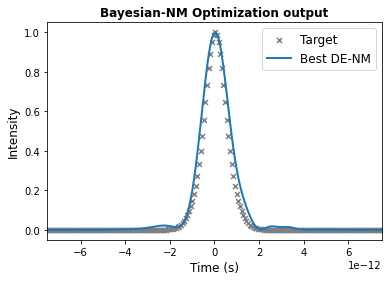

In [18]:
time, profile = l1_pump.forward_pass(optimized_solution)
fig, ax = plt.subplots()

ax.set_title("Bayesian-NM Optimization output", fontweight = "bold")
ax.scatter(losses.target_time, losses.target_profile, marker = "x", c = "grey", s = 25, label = "Target")
ax.plot(losses.target_time, np.roll(profile, - np.argmax(profile) + np.argmax(losses.target_profile)), label = "Best DE-NM", lw = 2)

ax.set_xlim(-7.5e-12, 7.5e-12); ax.set_xlabel("Time (s)", fontsize = 12); ax.set_ylabel("Intensity", fontsize = 12)
ax.legend(fontsize = 12)
plt.show()

In [22]:
# Initialize lists to store objective function values
objective_values = []
f_ev = []

# Define the bounds
bounds = np.array(((-5.31305788e-01, -4.17101926e-01), (-3.14772231e+08, 3.01620182e+08), (-2.55151879e+15, 1.56859005e+15)))

# Define the number of iterations and other parameters
num_iterations = 100
print_progress = 1

# Run optimization loop
for i in range(num_iterations):
    # Run Bayesian-NM optimization
    best_configuration, best_objective = bayesian_optimization(losses.lossb, bounds, n_iter=1, xi=0.02, decimal_precision1 = 5, decimal_precision2 = -2, decimal_precision3 = -3)
    optimized_solution, min_function_value, nfev, success, termination_reason, num_iterations, optimized_solutions = rounded_nelder_mead(losses.loss3, best_configuration, bounds, print_progress, decimal_precision1 = 3, decimal_precision2 = -5, decimal_precision3 = -13, maxiter=70)

    # Append objective value to list
    objective_values.append(min_function_value)
    f_ev.append(nfev)

# Calculate average and minimum objective function values
average_objective = np.mean(objective_values)
minimum_objective = np.min(objective_values)
average_fev = np.mean(f_ev)

# Print results
print("Average Objective Function Value:", average_objective)
print("Minimum Objective Function Value:", minimum_objective)
print("Average Number of Function Evaluations:", average_fev+201)

-20.66389601611503
iteration: 1
best value of objective function so far: 20.002463665732623
best candidate: [-4.79580000e-01 -1.50922000e+07  1.56859005e+15]
iteration: 2
best value of objective function so far: 20.002463665732623
best candidate: [-4.79580000e-01 -1.50922000e+07  1.56859005e+15]
iteration: 3
best value of objective function so far: 20.002463665732623
best candidate: [-4.79580000e-01 -1.50922000e+07  1.56859005e+15]
iteration: 4
best value of objective function so far: 20.002463665732623
best candidate: [-4.79580000e-01 -1.50922000e+07  1.56859005e+15]
iteration: 5
best value of objective function so far: 20.002463665732623
best candidate: [-4.79580000e-01 -1.50922000e+07  1.56859005e+15]
iteration: 6
best value of objective function so far: 20.002463665732623
best candidate: [-4.79580000e-01 -1.50922000e+07  1.56859005e+15]
iteration: 7
best value of objective function so far: 20.002463665732623
best candidate: [-4.79580000e-01 -1.50922000e+07  1.56859005e+15]
iteratio

iteration: 70
best value of objective function so far: 4.13589423293218
best candidate: [-4.75e-01 -6.40e+06 -1.77e+15]
-8.12886845581063
iteration: 1
best value of objective function so far: 7.380863353659738
best candidate: [-4.77440000e-01 -4.88820000e+06  1.56859005e+15]
iteration: 2
best value of objective function so far: 7.380863353659738
best candidate: [-4.77440000e-01 -4.88820000e+06  1.56859005e+15]
iteration: 3
best value of objective function so far: 7.380863353659738
best candidate: [-4.77440000e-01 -4.88820000e+06  1.56859005e+15]
iteration: 4
best value of objective function so far: 7.380863353659738
best candidate: [-4.77440000e-01 -4.88820000e+06  1.56859005e+15]
iteration: 5
best value of objective function so far: 7.380863353659738
best candidate: [-4.77440000e-01 -4.88820000e+06  1.56859005e+15]
iteration: 6
best value of objective function so far: 7.380863353659738
best candidate: [-4.77440000e-01 -4.88820000e+06  1.56859005e+15]
iteration: 7
best value of objecti

iteration: 32
best value of objective function so far: 2.1579139223032415
best candidate: [-4.75e-01 -7.30e+06 -3.30e+14]
iteration: 33
best value of objective function so far: 2.1579139223032415
best candidate: [-4.75e-01 -7.30e+06 -3.30e+14]
iteration: 34
best value of objective function so far: 2.1579139223032415
best candidate: [-4.75e-01 -7.30e+06 -3.30e+14]
iteration: 35
best value of objective function so far: 2.1579139223032415
best candidate: [-4.75e-01 -7.30e+06 -3.30e+14]
iteration: 36
best value of objective function so far: 2.1579139223032415
best candidate: [-4.75e-01 -7.30e+06 -3.30e+14]
iteration: 37
best value of objective function so far: 2.1579139223032415
best candidate: [-4.75e-01 -7.30e+06 -3.30e+14]
iteration: 38
best value of objective function so far: 2.1579139223032415
best candidate: [-4.75e-01 -7.30e+06 -3.30e+14]
iteration: 39
best value of objective function so far: 2.1579139223032415
best candidate: [-4.75e-01 -7.30e+06 -3.30e+14]
iteration: 40
best value

iteration: 30
best value of objective function so far: 10.080170760071825
best candidate: [-4.78e-01 -1.41e+07  1.12e+15]
iteration: 31
best value of objective function so far: 10.040064718231584
best candidate: [-4.78e-01 -1.40e+07  1.31e+15]
iteration: 32
best value of objective function so far: 9.982725897180208
best candidate: [-4.78e-01 -1.38e+07  1.57e+15]
iteration: 33
best value of objective function so far: 9.982725897180208
best candidate: [-4.78e-01 -1.38e+07  1.57e+15]
iteration: 34
best value of objective function so far: 9.930030021809513
best candidate: [-4.78e-01 -1.35e+07  1.57e+15]
iteration: 35
best value of objective function so far: 9.930030021809513
best candidate: [-4.78e-01 -1.35e+07  1.57e+15]
iteration: 36
best value of objective function so far: 9.930030021809513
best candidate: [-4.78e-01 -1.35e+07  1.57e+15]
iteration: 37
best value of objective function so far: 9.930030021809513
best candidate: [-4.78e-01 -1.35e+07  1.57e+15]
iteration: 38
best value of ob

iteration: 57
best value of objective function so far: 2.2725569532851426
best candidate: [-4.75e-01 -7.10e+06  8.10e+14]
iteration: 58
best value of objective function so far: 2.2725569532851426
best candidate: [-4.75e-01 -7.10e+06  8.10e+14]
iteration: 59
best value of objective function so far: 2.2725569532851426
best candidate: [-4.75e-01 -7.10e+06  8.10e+14]
iteration: 60
best value of objective function so far: 2.2725569532851426
best candidate: [-4.75e-01 -7.10e+06  8.10e+14]
iteration: 61
best value of objective function so far: 2.2725569532851426
best candidate: [-4.75e-01 -7.10e+06  8.10e+14]
iteration: 62
best value of objective function so far: 2.2725569532851426
best candidate: [-4.75e-01 -7.10e+06  8.10e+14]
iteration: 63
best value of objective function so far: 2.2725569532851426
best candidate: [-4.75e-01 -7.10e+06  8.10e+14]
iteration: 64
best value of objective function so far: 2.2725569532851426
best candidate: [-4.75e-01 -7.10e+06  8.10e+14]
iteration: 65
best value

iteration: 55
best value of objective function so far: 3.3257726059147545
best candidate: [-4.76e-01 -9.10e+06 -4.30e+14]
iteration: 56
best value of objective function so far: 3.3257726059147545
best candidate: [-4.76e-01 -9.10e+06 -4.30e+14]
iteration: 57
best value of objective function so far: 3.3257726059147545
best candidate: [-4.76e-01 -9.10e+06 -4.30e+14]
iteration: 58
best value of objective function so far: 3.3257726059147545
best candidate: [-4.76e-01 -9.10e+06 -4.30e+14]
iteration: 59
best value of objective function so far: 3.3257726059147545
best candidate: [-4.76e-01 -9.10e+06 -4.30e+14]
iteration: 60
best value of objective function so far: 3.3257726059147545
best candidate: [-4.76e-01 -9.10e+06 -4.30e+14]
iteration: 61
best value of objective function so far: 3.3257726059147545
best candidate: [-4.76e-01 -9.10e+06 -4.30e+14]
iteration: 62
best value of objective function so far: 3.3257726059147545
best candidate: [-4.76e-01 -9.10e+06 -4.30e+14]
iteration: 63
best value

iteration: 52
best value of objective function so far: 2.550389323188409
best candidate: [-4.75e-01 -7.40e+06  3.60e+14]
iteration: 53
best value of objective function so far: 2.550389323188409
best candidate: [-4.75e-01 -7.40e+06  3.60e+14]
iteration: 54
best value of objective function so far: 2.550389323188409
best candidate: [-4.75e-01 -7.40e+06  3.60e+14]
iteration: 55
best value of objective function so far: 2.550389323188409
best candidate: [-4.75e-01 -7.40e+06  3.60e+14]
iteration: 56
best value of objective function so far: 2.550389323188409
best candidate: [-4.75e-01 -7.40e+06  3.60e+14]
iteration: 57
best value of objective function so far: 2.550389323188409
best candidate: [-4.75e-01 -7.40e+06  3.60e+14]
iteration: 58
best value of objective function so far: 2.550389323188409
best candidate: [-4.75e-01 -7.40e+06  3.60e+14]
iteration: 59
best value of objective function so far: 2.550389323188409
best candidate: [-4.75e-01 -7.40e+06  3.60e+14]
iteration: 60
best value of obje

iteration: 52
best value of objective function so far: 2.810528876712947
best candidate: [-4.75e-01 -7.10e+06  1.29e+15]
iteration: 53
best value of objective function so far: 2.810528876712947
best candidate: [-4.75e-01 -7.10e+06  1.29e+15]
iteration: 54
best value of objective function so far: 2.810528876712947
best candidate: [-4.75e-01 -7.10e+06  1.29e+15]
iteration: 55
best value of objective function so far: 2.810528876712947
best candidate: [-4.75e-01 -7.10e+06  1.29e+15]
iteration: 56
best value of objective function so far: 2.810528876712947
best candidate: [-4.75e-01 -7.10e+06  1.29e+15]
iteration: 57
best value of objective function so far: 2.810528876712947
best candidate: [-4.75e-01 -7.10e+06  1.29e+15]
iteration: 58
best value of objective function so far: 2.810528876712947
best candidate: [-4.75e-01 -7.10e+06  1.29e+15]
iteration: 59
best value of objective function so far: 2.810528876712947
best candidate: [-4.75e-01 -7.10e+06  1.29e+15]
iteration: 60
best value of obje

iteration: 53
best value of objective function so far: 24.944731385804197
best candidate: [-4.88e-01  1.59e+07 -2.55e+15]
iteration: 54
best value of objective function so far: 24.944731385804197
best candidate: [-4.88e-01  1.59e+07 -2.55e+15]
iteration: 55
best value of objective function so far: 24.944731385804197
best candidate: [-4.88e-01  1.59e+07 -2.55e+15]
iteration: 56
best value of objective function so far: 24.944731385804197
best candidate: [-4.88e-01  1.59e+07 -2.55e+15]
iteration: 57
best value of objective function so far: 24.944731385804197
best candidate: [-4.88e-01  1.59e+07 -2.55e+15]
iteration: 58
best value of objective function so far: 24.944731385804197
best candidate: [-4.88e-01  1.59e+07 -2.55e+15]
iteration: 59
best value of objective function so far: 24.944731385804197
best candidate: [-4.88e-01  1.59e+07 -2.55e+15]
iteration: 60
best value of objective function so far: 24.944731385804197
best candidate: [-4.88e-01  1.59e+07 -2.55e+15]
iteration: 61
best value

iteration: 54
best value of objective function so far: 5.283751087788518
best candidate: [-4.76e-01 -1.16e+07  8.60e+14]
iteration: 55
best value of objective function so far: 5.283751087788518
best candidate: [-4.76e-01 -1.16e+07  8.60e+14]
iteration: 56
best value of objective function so far: 5.283751087788518
best candidate: [-4.76e-01 -1.16e+07  8.60e+14]
iteration: 57
best value of objective function so far: 5.283751087788518
best candidate: [-4.76e-01 -1.16e+07  8.60e+14]
iteration: 58
best value of objective function so far: 5.283751087788518
best candidate: [-4.76e-01 -1.16e+07  8.60e+14]
iteration: 59
best value of objective function so far: 5.283751087788518
best candidate: [-4.76e-01 -1.16e+07  8.60e+14]
iteration: 60
best value of objective function so far: 5.283751087788518
best candidate: [-4.76e-01 -1.16e+07  8.60e+14]
iteration: 61
best value of objective function so far: 5.283751087788518
best candidate: [-4.76e-01 -1.16e+07  8.60e+14]
iteration: 62
best value of obje

iteration: 52
best value of objective function so far: 7.3993989391401
best candidate: [-4.78e-01 -1.30e+06 -2.17e+15]
iteration: 53
best value of objective function so far: 7.3993989391401
best candidate: [-4.78e-01 -1.30e+06 -2.17e+15]
iteration: 54
best value of objective function so far: 7.3993989391401
best candidate: [-4.78e-01 -1.30e+06 -2.17e+15]
iteration: 55
best value of objective function so far: 7.3993989391401
best candidate: [-4.78e-01 -1.30e+06 -2.17e+15]
iteration: 56
best value of objective function so far: 7.3993989391401
best candidate: [-4.78e-01 -1.30e+06 -2.17e+15]
iteration: 57
best value of objective function so far: 7.3993989391401
best candidate: [-4.78e-01 -1.30e+06 -2.17e+15]
iteration: 58
best value of objective function so far: 7.3993989391401
best candidate: [-4.78e-01 -1.30e+06 -2.17e+15]
iteration: 59
best value of objective function so far: 7.3993989391401
best candidate: [-4.78e-01 -1.30e+06 -2.17e+15]
iteration: 60
best value of objective function s

iteration: 10
best value of objective function so far: 20.987085075471988
best candidate: [-4.79e-01 -8.00e+06 -2.60e+14]
iteration: 11
best value of objective function so far: 20.987085075471988
best candidate: [-4.79e-01 -8.00e+06 -2.60e+14]
iteration: 12
best value of objective function so far: 19.03109806874604
best candidate: [-4.8e-01  8.4e+06 -4.0e+13]
iteration: 13
best value of objective function so far: 15.890013544290444
best candidate: [-4.82e-01  6.50e+06 -1.80e+14]
iteration: 14
best value of objective function so far: 14.321086769361777
best candidate: [-4.8e-01  5.0e+06 -2.7e+14]
iteration: 15
best value of objective function so far: 11.467555407986362
best candidate: [-4.8e-01  1.2e+06 -2.0e+14]
iteration: 16
best value of objective function so far: 11.467555407986362
best candidate: [-4.8e-01  1.2e+06 -2.0e+14]
iteration: 17
best value of objective function so far: 11.467555407986362
best candidate: [-4.8e-01  1.2e+06 -2.0e+14]
iteration: 18
best value of objective fu

iteration: 9
best value of objective function so far: 10.97128846023614
best candidate: [-4.78e-01 -1.61e+07  3.00e+13]
iteration: 10
best value of objective function so far: 10.97128846023614
best candidate: [-4.78e-01 -1.61e+07  3.00e+13]
iteration: 11
best value of objective function so far: 10.97128846023614
best candidate: [-4.78e-01 -1.61e+07  3.00e+13]
iteration: 12
best value of objective function so far: 7.504533504342826
best candidate: [-4.77e-01 -4.60e+06 -5.90e+14]
iteration: 13
best value of objective function so far: 3.507591128231666
best candidate: [-4.76e-01 -8.70e+06 -4.60e+14]
iteration: 14
best value of objective function so far: 3.507591128231666
best candidate: [-4.76e-01 -8.70e+06 -4.60e+14]
iteration: 15
best value of objective function so far: 3.507591128231666
best candidate: [-4.76e-01 -8.70e+06 -4.60e+14]
iteration: 16
best value of objective function so far: 3.507591128231666
best candidate: [-4.76e-01 -8.70e+06 -4.60e+14]
iteration: 17
best value of objec

iteration: 7
best value of objective function so far: 22.08403880808427
best candidate: [-4.77470000e-01 -3.11565000e+07  2.97501455e+14]
iteration: 8
best value of objective function so far: 17.2412178472991
best candidate: [-4.83e-01  5.60e+06  9.40e+14]
iteration: 9
best value of objective function so far: 17.2412178472991
best candidate: [-4.83e-01  5.60e+06  9.40e+14]
iteration: 10
best value of objective function so far: 17.2412178472991
best candidate: [-4.83e-01  5.60e+06  9.40e+14]
iteration: 11
best value of objective function so far: 17.2412178472991
best candidate: [-4.83e-01  5.60e+06  9.40e+14]
iteration: 12
best value of objective function so far: 15.418617839327501
best candidate: [-4.82e-01  4.30e+06  1.09e+15]
iteration: 13
best value of objective function so far: 15.418617839327501
best candidate: [-4.82e-01  4.30e+06  1.09e+15]
iteration: 14
best value of objective function so far: 15.418617839327501
best candidate: [-4.82e-01  4.30e+06  1.09e+15]
iteration: 15
best

iteration: 9
best value of objective function so far: 18.207980304840834
best candidate: [-4.83e-01  9.00e+06  1.80e+14]
iteration: 10
best value of objective function so far: 15.70253929133794
best candidate: [-4.82e-01  3.40e+06  1.70e+14]
iteration: 11
best value of objective function so far: 15.70253929133794
best candidate: [-4.82e-01  3.40e+06  1.70e+14]
iteration: 12
best value of objective function so far: 15.70253929133794
best candidate: [-4.82e-01  3.40e+06  1.70e+14]
iteration: 13
best value of objective function so far: 15.70253929133794
best candidate: [-4.82e-01  3.40e+06  1.70e+14]
iteration: 14
best value of objective function so far: 15.280669644158825
best candidate: [-4.82e-01  5.10e+06 -2.20e+14]
iteration: 15
best value of objective function so far: 14.512108951529951
best candidate: [-4.81e-01  1.50e+06 -7.30e+14]
iteration: 16
best value of objective function so far: 14.512108951529951
best candidate: [-4.81e-01  1.50e+06 -7.30e+14]
iteration: 17
best value of o

iteration: 11
best value of objective function so far: 18.418289972583928
best candidate: [-4.73e-01 -5.40e+06  1.10e+14]
iteration: 12
best value of objective function so far: 7.293424606446031
best candidate: [-4.75e-01 -1.19e+07  1.05e+15]
iteration: 13
best value of objective function so far: 7.293424606446031
best candidate: [-4.75e-01 -1.19e+07  1.05e+15]
iteration: 14
best value of objective function so far: 7.293424606446031
best candidate: [-4.75e-01 -1.19e+07  1.05e+15]
iteration: 15
best value of objective function so far: 7.293424606446031
best candidate: [-4.75e-01 -1.19e+07  1.05e+15]
iteration: 16
best value of objective function so far: 7.293424606446031
best candidate: [-4.75e-01 -1.19e+07  1.05e+15]
iteration: 17
best value of objective function so far: 7.293424606446031
best candidate: [-4.75e-01 -1.19e+07  1.05e+15]
iteration: 18
best value of objective function so far: 7.293424606446031
best candidate: [-4.75e-01 -1.19e+07  1.05e+15]
iteration: 19
best value of obj

iteration: 10
best value of objective function so far: 12.246864796816553
best candidate: [-4.76e-01 -1.96e+07 -1.60e+14]
iteration: 11
best value of objective function so far: 10.530510713987653
best candidate: [-4.74e-01 -1.01e+07 -3.00e+14]
iteration: 12
best value of objective function so far: 10.530510713987653
best candidate: [-4.74e-01 -1.01e+07 -3.00e+14]
iteration: 13
best value of objective function so far: 5.845057590571773
best candidate: [-4.75e-01 -1.09e+07 -1.45e+15]
iteration: 14
best value of objective function so far: 5.845057590571773
best candidate: [-4.75e-01 -1.09e+07 -1.45e+15]
iteration: 15
best value of objective function so far: 5.845057590571773
best candidate: [-4.75e-01 -1.09e+07 -1.45e+15]
iteration: 16
best value of objective function so far: 5.845057590571773
best candidate: [-4.75e-01 -1.09e+07 -1.45e+15]
iteration: 17
best value of objective function so far: 5.845057590571773
best candidate: [-4.75e-01 -1.09e+07 -1.45e+15]
iteration: 18
best value of o

iteration: 11
best value of objective function so far: 10.27844010621284
best candidate: [-4.78e-01 -1.46e+07  4.60e+14]
iteration: 12
best value of objective function so far: 10.27844010621284
best candidate: [-4.78e-01 -1.46e+07  4.60e+14]
iteration: 13
best value of objective function so far: 10.27844010621284
best candidate: [-4.78e-01 -1.46e+07  4.60e+14]
iteration: 14
best value of objective function so far: 10.27844010621284
best candidate: [-4.78e-01 -1.46e+07  4.60e+14]
iteration: 15
best value of objective function so far: 10.226844059759914
best candidate: [-4.78e-01 -1.35e+07  2.30e+14]
iteration: 16
best value of objective function so far: 10.226844059759914
best candidate: [-4.78e-01 -1.35e+07  2.30e+14]
iteration: 17
best value of objective function so far: 10.189803115142997
best candidate: [-4.78e-01 -1.33e+07  5.00e+14]
iteration: 18
best value of objective function so far: 10.189803115142997
best candidate: [-4.78e-01 -1.33e+07  5.00e+14]
iteration: 19
best value of 

iteration: 11
best value of objective function so far: 9.24180578211222
best candidate: [-4.76e-01 -2.40e+06  7.90e+14]
iteration: 12
best value of objective function so far: 9.24180578211222
best candidate: [-4.76e-01 -2.40e+06  7.90e+14]
iteration: 13
best value of objective function so far: 9.24180578211222
best candidate: [-4.76e-01 -2.40e+06  7.90e+14]
iteration: 14
best value of objective function so far: 9.24180578211222
best candidate: [-4.76e-01 -2.40e+06  7.90e+14]
iteration: 15
best value of objective function so far: 9.24180578211222
best candidate: [-4.76e-01 -2.40e+06  7.90e+14]
iteration: 16
best value of objective function so far: 3.1252224748273023
best candidate: [-4.75e-01 -6.40e+06  1.18e+15]
iteration: 17
best value of objective function so far: 3.1252224748273023
best candidate: [-4.75e-01 -6.40e+06  1.18e+15]
iteration: 18
best value of objective function so far: 3.1252224748273023
best candidate: [-4.75e-01 -6.40e+06  1.18e+15]
iteration: 19
best value of object

iteration: 32
best value of objective function so far: 3.1730269733411594
best candidate: [-4.75e-01 -7.70e+06  1.22e+15]
iteration: 33
best value of objective function so far: 3.1730269733411594
best candidate: [-4.75e-01 -7.70e+06  1.22e+15]
iteration: 34
best value of objective function so far: 3.1730269733411594
best candidate: [-4.75e-01 -7.70e+06  1.22e+15]
iteration: 35
best value of objective function so far: 3.1730269733411594
best candidate: [-4.75e-01 -7.70e+06  1.22e+15]
iteration: 36
best value of objective function so far: 3.1730269733411594
best candidate: [-4.75e-01 -7.70e+06  1.22e+15]
iteration: 37
best value of objective function so far: 3.1730269733411594
best candidate: [-4.75e-01 -7.70e+06  1.22e+15]
iteration: 38
best value of objective function so far: 3.1730269733411594
best candidate: [-4.75e-01 -7.70e+06  1.22e+15]
iteration: 39
best value of objective function so far: 3.1730269733411594
best candidate: [-4.75e-01 -7.70e+06  1.22e+15]
iteration: 40
best value

iteration: 32
best value of objective function so far: 2.8030326237717356
best candidate: [-4.76e-01 -8.20e+06  1.50e+15]
iteration: 33
best value of objective function so far: 2.8030326237717356
best candidate: [-4.76e-01 -8.20e+06  1.50e+15]
iteration: 34
best value of objective function so far: 2.8030326237717356
best candidate: [-4.76e-01 -8.20e+06  1.50e+15]
iteration: 35
best value of objective function so far: 2.8030326237717356
best candidate: [-4.76e-01 -8.20e+06  1.50e+15]
iteration: 36
best value of objective function so far: 2.8030326237717356
best candidate: [-4.76e-01 -8.20e+06  1.50e+15]
-8.86806582207003
iteration: 1
best value of objective function so far: 8.139430007626276
best candidate: [-4.77530000e-01 -1.29456000e+07  1.56859005e+15]
iteration: 2
best value of objective function so far: 8.139430007626276
best candidate: [-4.77530000e-01 -1.29456000e+07  1.56859005e+15]
iteration: 3
best value of objective function so far: 8.139430007626276
best candidate: [-4.7753

iteration: 58
best value of objective function so far: 8.139430007626276
best candidate: [-4.77530000e-01 -1.29456000e+07  1.56859005e+15]
iteration: 59
best value of objective function so far: 8.139430007626276
best candidate: [-4.77530000e-01 -1.29456000e+07  1.56859005e+15]
iteration: 60
best value of objective function so far: 8.139430007626276
best candidate: [-4.77530000e-01 -1.29456000e+07  1.56859005e+15]
iteration: 61
best value of objective function so far: 8.139430007626276
best candidate: [-4.77530000e-01 -1.29456000e+07  1.56859005e+15]
iteration: 62
best value of objective function so far: 8.139430007626276
best candidate: [-4.77530000e-01 -1.29456000e+07  1.56859005e+15]
iteration: 63
best value of objective function so far: 8.139430007626276
best candidate: [-4.77530000e-01 -1.29456000e+07  1.56859005e+15]
iteration: 64
best value of objective function so far: 8.139430007626276
best candidate: [-4.77530000e-01 -1.29456000e+07  1.56859005e+15]
iteration: 65
best value of

iteration: 55
best value of objective function so far: 2.6167287121148237
best candidate: [-4.75e-01 -7.20e+06  1.15e+15]
iteration: 56
best value of objective function so far: 2.6167287121148237
best candidate: [-4.75e-01 -7.20e+06  1.15e+15]
iteration: 57
best value of objective function so far: 2.6167287121148237
best candidate: [-4.75e-01 -7.20e+06  1.15e+15]
iteration: 58
best value of objective function so far: 2.6167287121148237
best candidate: [-4.75e-01 -7.20e+06  1.15e+15]
iteration: 59
best value of objective function so far: 2.6167287121148237
best candidate: [-4.75e-01 -7.20e+06  1.15e+15]
iteration: 60
best value of objective function so far: 2.6167287121148237
best candidate: [-4.75e-01 -7.20e+06  1.15e+15]
iteration: 61
best value of objective function so far: 2.6167287121148237
best candidate: [-4.75e-01 -7.20e+06  1.15e+15]
iteration: 62
best value of objective function so far: 2.6167287121148237
best candidate: [-4.75e-01 -7.20e+06  1.15e+15]
iteration: 63
best value

iteration: 56
best value of objective function so far: 2.8107666013900734
best candidate: [-4.76e-01 -8.20e+06  1.47e+15]
iteration: 57
best value of objective function so far: 2.8107666013900734
best candidate: [-4.76e-01 -8.20e+06  1.47e+15]
iteration: 58
best value of objective function so far: 2.8107666013900734
best candidate: [-4.76e-01 -8.20e+06  1.47e+15]
iteration: 59
best value of objective function so far: 2.8107666013900734
best candidate: [-4.76e-01 -8.20e+06  1.47e+15]
iteration: 60
best value of objective function so far: 2.8107666013900734
best candidate: [-4.76e-01 -8.20e+06  1.47e+15]
iteration: 61
best value of objective function so far: 2.8107666013900734
best candidate: [-4.76e-01 -8.20e+06  1.47e+15]
iteration: 62
best value of objective function so far: 2.8107666013900734
best candidate: [-4.76e-01 -8.20e+06  1.47e+15]
iteration: 63
best value of objective function so far: 2.8107666013900734
best candidate: [-4.76e-01 -8.20e+06  1.47e+15]
iteration: 64
best value

iteration: 57
best value of objective function so far: 2.1183991748144195
best candidate: [-4.75e-01 -7.10e+06 -1.50e+14]
iteration: 58
best value of objective function so far: 2.1183991748144195
best candidate: [-4.75e-01 -7.10e+06 -1.50e+14]
iteration: 59
best value of objective function so far: 2.1183991748144195
best candidate: [-4.75e-01 -7.10e+06 -1.50e+14]
iteration: 60
best value of objective function so far: 2.1183991748144195
best candidate: [-4.75e-01 -7.10e+06 -1.50e+14]
iteration: 61
best value of objective function so far: 2.1183991748144195
best candidate: [-4.75e-01 -7.10e+06 -1.50e+14]
iteration: 62
best value of objective function so far: 2.1183991748144195
best candidate: [-4.75e-01 -7.10e+06 -1.50e+14]
iteration: 63
best value of objective function so far: 2.1183991748144195
best candidate: [-4.75e-01 -7.10e+06 -1.50e+14]
iteration: 64
best value of objective function so far: 2.1183991748144195
best candidate: [-4.75e-01 -7.10e+06 -1.50e+14]
iteration: 65
best value

iteration: 54
best value of objective function so far: 2.178266072742662
best candidate: [-4.75e-01 -8.30e+06 -1.58e+15]
iteration: 55
best value of objective function so far: 2.178266072742662
best candidate: [-4.75e-01 -8.30e+06 -1.58e+15]
iteration: 56
best value of objective function so far: 2.178266072742662
best candidate: [-4.75e-01 -8.30e+06 -1.58e+15]
iteration: 57
best value of objective function so far: 2.178266072742662
best candidate: [-4.75e-01 -8.30e+06 -1.58e+15]
iteration: 58
best value of objective function so far: 2.178266072742662
best candidate: [-4.75e-01 -8.30e+06 -1.58e+15]
iteration: 59
best value of objective function so far: 2.178266072742662
best candidate: [-4.75e-01 -8.30e+06 -1.58e+15]
iteration: 60
best value of objective function so far: 2.178266072742662
best candidate: [-4.75e-01 -8.30e+06 -1.58e+15]
iteration: 61
best value of objective function so far: 2.178266072742662
best candidate: [-4.75e-01 -8.30e+06 -1.58e+15]
iteration: 62
best value of obje

iteration: 53
best value of objective function so far: 2.8289658473840658
best candidate: [-4.76e-01 -8.30e+06  1.40e+15]
iteration: 54
best value of objective function so far: 2.8289658473840658
best candidate: [-4.76e-01 -8.30e+06  1.40e+15]
iteration: 55
best value of objective function so far: 2.8289658473840658
best candidate: [-4.76e-01 -8.30e+06  1.40e+15]
iteration: 56
best value of objective function so far: 2.8289658473840658
best candidate: [-4.76e-01 -8.30e+06  1.40e+15]
iteration: 57
best value of objective function so far: 2.8289658473840658
best candidate: [-4.76e-01 -8.30e+06  1.40e+15]
iteration: 58
best value of objective function so far: 2.8289658473840658
best candidate: [-4.76e-01 -8.30e+06  1.40e+15]
iteration: 59
best value of objective function so far: 2.8289658473840658
best candidate: [-4.76e-01 -8.30e+06  1.40e+15]
iteration: 60
best value of objective function so far: 2.8289658473840658
best candidate: [-4.76e-01 -8.30e+06  1.40e+15]
iteration: 61
best value

iteration: 49
best value of objective function so far: 10.049196912373526
best candidate: [-4.78e-01 -1.36e+07  9.80e+14]
iteration: 50
best value of objective function so far: 10.049196912373526
best candidate: [-4.78e-01 -1.36e+07  9.80e+14]
iteration: 51
best value of objective function so far: 10.049196912373526
best candidate: [-4.78e-01 -1.36e+07  9.80e+14]
iteration: 52
best value of objective function so far: 10.049196912373526
best candidate: [-4.78e-01 -1.36e+07  9.80e+14]
iteration: 53
best value of objective function so far: 10.049196912373526
best candidate: [-4.78e-01 -1.36e+07  9.80e+14]
iteration: 54
best value of objective function so far: 10.049196912373526
best candidate: [-4.78e-01 -1.36e+07  9.80e+14]
iteration: 55
best value of objective function so far: 10.049196912373526
best candidate: [-4.78e-01 -1.36e+07  9.80e+14]
iteration: 56
best value of objective function so far: 10.049196912373526
best candidate: [-4.78e-01 -1.36e+07  9.80e+14]
iteration: 57
best value

iteration: 46
best value of objective function so far: 3.5826589661908432
best candidate: [-4.76e-01 -9.90e+06 -1.72e+15]
iteration: 47
best value of objective function so far: 3.5826589661908432
best candidate: [-4.76e-01 -9.90e+06 -1.72e+15]
iteration: 48
best value of objective function so far: 3.5826589661908432
best candidate: [-4.76e-01 -9.90e+06 -1.72e+15]
iteration: 49
best value of objective function so far: 3.5826589661908432
best candidate: [-4.76e-01 -9.90e+06 -1.72e+15]
iteration: 50
best value of objective function so far: 3.5826589661908432
best candidate: [-4.76e-01 -9.90e+06 -1.72e+15]
iteration: 51
best value of objective function so far: 3.5826589661908432
best candidate: [-4.76e-01 -9.90e+06 -1.72e+15]
iteration: 52
best value of objective function so far: 3.5826589661908432
best candidate: [-4.76e-01 -9.90e+06 -1.72e+15]
iteration: 53
best value of objective function so far: 3.5826589661908432
best candidate: [-4.76e-01 -9.90e+06 -1.72e+15]
iteration: 54
best value

iteration: 44
best value of objective function so far: 3.30563544247128
best candidate: [-4.76e-01 -6.00e+06  1.34e+15]
iteration: 45
best value of objective function so far: 3.30563544247128
best candidate: [-4.76e-01 -6.00e+06  1.34e+15]
iteration: 46
best value of objective function so far: 3.30563544247128
best candidate: [-4.76e-01 -6.00e+06  1.34e+15]
iteration: 47
best value of objective function so far: 3.30563544247128
best candidate: [-4.76e-01 -6.00e+06  1.34e+15]
iteration: 48
best value of objective function so far: 3.30563544247128
best candidate: [-4.76e-01 -6.00e+06  1.34e+15]
iteration: 49
best value of objective function so far: 3.30563544247128
best candidate: [-4.76e-01 -6.00e+06  1.34e+15]
iteration: 50
best value of objective function so far: 3.30563544247128
best candidate: [-4.76e-01 -6.00e+06  1.34e+15]
iteration: 51
best value of objective function so far: 3.30563544247128
best candidate: [-4.76e-01 -6.00e+06  1.34e+15]
iteration: 52
best value of objective fu

best value of objective function so far: 27.664001705563162
best candidate: [-4.72e-01  2.90e+06  2.40e+14]
iteration: 10
best value of objective function so far: 23.231677980753126
best candidate: [-4.72e-01 -4.10e+06  2.50e+14]
iteration: 11
best value of objective function so far: 23.231677980753126
best candidate: [-4.72e-01 -4.10e+06  2.50e+14]
iteration: 12
best value of objective function so far: 23.231677980753126
best candidate: [-4.72e-01 -4.10e+06  2.50e+14]
iteration: 13
best value of objective function so far: 23.231677980753126
best candidate: [-4.72e-01 -4.10e+06  2.50e+14]
iteration: 14
best value of objective function so far: 23.231677980753126
best candidate: [-4.72e-01 -4.10e+06  2.50e+14]
iteration: 15
best value of objective function so far: 23.231677980753126
best candidate: [-4.72e-01 -4.10e+06  2.50e+14]
iteration: 16
best value of objective function so far: 17.978056325325536
best candidate: [-4.74e-01 -2.40e+06 -1.21e+15]
iteration: 17
best value of objective 

iteration: 10
best value of objective function so far: 10.332124070167422
best candidate: [-4.78e-01 -1.49e+07  9.00e+14]
iteration: 11
best value of objective function so far: 10.332124070167422
best candidate: [-4.78e-01 -1.49e+07  9.00e+14]
iteration: 12
best value of objective function so far: 10.332124070167422
best candidate: [-4.78e-01 -1.49e+07  9.00e+14]
iteration: 13
best value of objective function so far: 10.332124070167422
best candidate: [-4.78e-01 -1.49e+07  9.00e+14]
iteration: 14
best value of objective function so far: 10.133727023526967
best candidate: [-4.78e-01 -1.41e+07  7.50e+14]
iteration: 15
best value of objective function so far: 10.133727023526967
best candidate: [-4.78e-01 -1.41e+07  7.50e+14]
iteration: 16
best value of objective function so far: 5.4388815576390925
best candidate: [-4.76e-01 -1.17e+07  1.35e+15]
iteration: 17
best value of objective function so far: 5.4388815576390925
best candidate: [-4.76e-01 -1.17e+07  1.35e+15]
iteration: 18
best value

iteration: 14
best value of objective function so far: 4.483110885801752
best candidate: [-4.76e-01 -4.50e+06 -4.50e+14]
iteration: 15
best value of objective function so far: 3.724448770814437
best candidate: [-4.75e-01 -8.80e+06 -5.40e+14]
iteration: 16
best value of objective function so far: 3.724448770814437
best candidate: [-4.75e-01 -8.80e+06 -5.40e+14]
iteration: 17
best value of objective function so far: 2.1749969292008604
best candidate: [-4.75e-01 -6.90e+06  7.80e+14]
iteration: 18
best value of objective function so far: 2.1749969292008604
best candidate: [-4.75e-01 -6.90e+06  7.80e+14]
iteration: 19
best value of objective function so far: 2.1749969292008604
best candidate: [-4.75e-01 -6.90e+06  7.80e+14]
iteration: 20
best value of objective function so far: 2.1749969292008604
best candidate: [-4.75e-01 -6.90e+06  7.80e+14]
iteration: 21
best value of objective function so far: 2.1749969292008604
best candidate: [-4.75e-01 -6.90e+06  7.80e+14]
iteration: 22
best value of

iteration: 18
best value of objective function so far: 4.652755382645208
best candidate: [-4.76e-01 -3.90e+06 -1.96e+15]
iteration: 19
best value of objective function so far: 4.652755382645208
best candidate: [-4.76e-01 -3.90e+06 -1.96e+15]
iteration: 20
best value of objective function so far: 4.652755382645208
best candidate: [-4.76e-01 -3.90e+06 -1.96e+15]
iteration: 21
best value of objective function so far: 4.652755382645208
best candidate: [-4.76e-01 -3.90e+06 -1.96e+15]
iteration: 22
best value of objective function so far: 4.652755382645208
best candidate: [-4.76e-01 -3.90e+06 -1.96e+15]
iteration: 23
best value of objective function so far: 4.652755382645208
best candidate: [-4.76e-01 -3.90e+06 -1.96e+15]
iteration: 24
best value of objective function so far: 4.652755382645208
best candidate: [-4.76e-01 -3.90e+06 -1.96e+15]
iteration: 25
best value of objective function so far: 4.652755382645208
best candidate: [-4.76e-01 -3.90e+06 -1.96e+15]
iteration: 26
best value of obje

iteration: 21
best value of objective function so far: 15.456819446879118
best candidate: [-4.80e-01  6.60e+06 -2.55e+15]
iteration: 22
best value of objective function so far: 13.181841530772601
best candidate: [-4.81e-01  3.50e+06 -2.21e+15]
iteration: 23
best value of objective function so far: 13.181841530772601
best candidate: [-4.81e-01  3.50e+06 -2.21e+15]
iteration: 24
best value of objective function so far: 9.34093192004386
best candidate: [-4.79e-01  6.00e+05 -2.28e+15]
iteration: 25
best value of objective function so far: 9.34093192004386
best candidate: [-4.79e-01  6.00e+05 -2.28e+15]
iteration: 26
best value of objective function so far: 9.34093192004386
best candidate: [-4.79e-01  6.00e+05 -2.28e+15]
iteration: 27
best value of objective function so far: 5.638959517026141
best candidate: [-4.76e-01 -5.40e+06 -2.03e+15]
iteration: 28
best value of objective function so far: 5.638959517026141
best candidate: [-4.76e-01 -5.40e+06 -2.03e+15]
iteration: 29
best value of obje

iteration: 21
best value of objective function so far: 11.864662122574344
best candidate: [-4.75e-01 -1.78e+07  1.57e+15]
iteration: 22
best value of objective function so far: 11.864662122574344
best candidate: [-4.75e-01 -1.78e+07  1.57e+15]
iteration: 23
best value of objective function so far: 7.4277667927128705
best candidate: [-4.77e-01 -1.36e+07  1.57e+15]
iteration: 24
best value of objective function so far: 7.4277667927128705
best candidate: [-4.77e-01 -1.36e+07  1.57e+15]
iteration: 25
best value of objective function so far: 7.4277667927128705
best candidate: [-4.77e-01 -1.36e+07  1.57e+15]
iteration: 26
best value of objective function so far: 7.225075416623657
best candidate: [-4.77e-01 -1.33e+07  1.57e+15]
iteration: 27
best value of objective function so far: 7.225075416623657
best candidate: [-4.77e-01 -1.33e+07  1.57e+15]
iteration: 28
best value of objective function so far: 7.225075416623657
best candidate: [-4.77e-01 -1.33e+07  1.57e+15]
iteration: 29
best value of

iteration: 18
best value of objective function so far: 5.304920678182263
best candidate: [-4.76e-01 -4.50e+06  1.20e+15]
iteration: 19
best value of objective function so far: 5.304920678182263
best candidate: [-4.76e-01 -4.50e+06  1.20e+15]
iteration: 20
best value of objective function so far: 5.304920678182263
best candidate: [-4.76e-01 -4.50e+06  1.20e+15]
iteration: 21
best value of objective function so far: 5.304920678182263
best candidate: [-4.76e-01 -4.50e+06  1.20e+15]
iteration: 22
best value of objective function so far: 5.304920678182263
best candidate: [-4.76e-01 -4.50e+06  1.20e+15]
iteration: 23
best value of objective function so far: 5.304920678182263
best candidate: [-4.76e-01 -4.50e+06  1.20e+15]
iteration: 24
best value of objective function so far: 5.304920678182263
best candidate: [-4.76e-01 -4.50e+06  1.20e+15]
iteration: 25
best value of objective function so far: 5.304920678182263
best candidate: [-4.76e-01 -4.50e+06  1.20e+15]
iteration: 26
best value of obje

best value of objective function so far: 4.045874375036642
best candidate: [-4.76e-01 -1.02e+07  1.57e+15]
iteration: 21
best value of objective function so far: 2.8705721810398726
best candidate: [-4.75e-01 -6.90e+06  1.25e+15]
iteration: 22
best value of objective function so far: 2.8705721810398726
best candidate: [-4.75e-01 -6.90e+06  1.25e+15]
iteration: 23
best value of objective function so far: 2.8705721810398726
best candidate: [-4.75e-01 -6.90e+06  1.25e+15]
iteration: 24
best value of objective function so far: 2.8705721810398726
best candidate: [-4.75e-01 -6.90e+06  1.25e+15]
iteration: 25
best value of objective function so far: 2.8705721810398726
best candidate: [-4.75e-01 -6.90e+06  1.25e+15]
iteration: 26
best value of objective function so far: 2.8705721810398726
best candidate: [-4.75e-01 -6.90e+06  1.25e+15]
iteration: 27
best value of objective function so far: 2.8588828757500195
best candidate: [-4.76e-01 -8.00e+06  1.34e+15]
iteration: 28
best value of objective f

iteration: 17
best value of objective function so far: 2.5299207088079907
best candidate: [-4.75e-01 -7.30e+06  8.50e+14]
iteration: 18
best value of objective function so far: 2.5299207088079907
best candidate: [-4.75e-01 -7.30e+06  8.50e+14]
iteration: 19
best value of objective function so far: 2.5299207088079907
best candidate: [-4.75e-01 -7.30e+06  8.50e+14]
iteration: 20
best value of objective function so far: 2.5299207088079907
best candidate: [-4.75e-01 -7.30e+06  8.50e+14]
iteration: 21
best value of objective function so far: 2.5299207088079907
best candidate: [-4.75e-01 -7.30e+06  8.50e+14]
iteration: 22
best value of objective function so far: 2.2974564391494483
best candidate: [-4.75e-01 -6.60e+06  7.80e+14]
iteration: 23
best value of objective function so far: 2.2074233532473975
best candidate: [-4.75e-01 -7.00e+06  8.20e+14]
iteration: 24
best value of objective function so far: 2.2074233532473975
best candidate: [-4.75e-01 -7.00e+06  8.20e+14]
iteration: 25
best value

iteration: 22
best value of objective function so far: 3.88130298905325
best candidate: [-4.76e-01 -1.05e+07 -2.19e+15]
iteration: 23
best value of objective function so far: 3.3913000197751293
best candidate: [-4.75e-01 -8.10e+06 -2.36e+15]
iteration: 24
best value of objective function so far: 2.879431827634622
best candidate: [-4.75e-01 -8.50e+06 -2.32e+15]
iteration: 25
best value of objective function so far: 2.879431827634622
best candidate: [-4.75e-01 -8.50e+06 -2.32e+15]
iteration: 26
best value of objective function so far: 2.879431827634622
best candidate: [-4.75e-01 -8.50e+06 -2.32e+15]
iteration: 27
best value of objective function so far: 2.879431827634622
best candidate: [-4.75e-01 -8.50e+06 -2.32e+15]
iteration: 28
best value of objective function so far: 2.879431827634622
best candidate: [-4.75e-01 -8.50e+06 -2.32e+15]
iteration: 29
best value of objective function so far: 2.879431827634622
best candidate: [-4.75e-01 -8.50e+06 -2.32e+15]
iteration: 30
best value of obje

iteration: 21
best value of objective function so far: 2.8961942974899455
best candidate: [-4.76e-01 -8.50e+06  1.52e+15]
iteration: 22
best value of objective function so far: 2.815712757099367
best candidate: [-4.76e-01 -8.00e+06  1.48e+15]
iteration: 23
best value of objective function so far: 2.810683184937318
best candidate: [-4.76e-01 -8.30e+06  1.50e+15]
iteration: 24
best value of objective function so far: 2.810683184937318
best candidate: [-4.76e-01 -8.30e+06  1.50e+15]
iteration: 25
best value of objective function so far: 2.8054851331582995
best candidate: [-4.76e-01 -8.20e+06  1.49e+15]
iteration: 26
best value of objective function so far: 2.8054851331582995
best candidate: [-4.76e-01 -8.20e+06  1.49e+15]
iteration: 27
best value of objective function so far: 2.8054851331582995
best candidate: [-4.76e-01 -8.20e+06  1.49e+15]
iteration: 28
best value of objective function so far: 2.8054851331582995
best candidate: [-4.76e-01 -8.20e+06  1.49e+15]
iteration: 29
best value of

iteration: 24
best value of objective function so far: 2.485754605904076
best candidate: [-4.75e-01 -7.30e+06  5.40e+14]
iteration: 25
best value of objective function so far: 2.485754605904076
best candidate: [-4.75e-01 -7.30e+06  5.40e+14]
iteration: 26
best value of objective function so far: 2.485754605904076
best candidate: [-4.75e-01 -7.30e+06  5.40e+14]
iteration: 27
best value of objective function so far: 2.485754605904076
best candidate: [-4.75e-01 -7.30e+06  5.40e+14]
iteration: 28
best value of objective function so far: 2.485754605904076
best candidate: [-4.75e-01 -7.30e+06  5.40e+14]
iteration: 29
best value of objective function so far: 2.485754605904076
best candidate: [-4.75e-01 -7.30e+06  5.40e+14]
iteration: 30
best value of objective function so far: 2.485754605904076
best candidate: [-4.75e-01 -7.30e+06  5.40e+14]
iteration: 31
best value of objective function so far: 2.485754605904076
best candidate: [-4.75e-01 -7.30e+06  5.40e+14]
iteration: 32
best value of obje

best candidate: [-4.75e-01 -6.10e+06  2.50e+14]
iteration: 22
best value of objective function so far: 3.853626802214279
best candidate: [-4.75e-01 -6.10e+06  2.50e+14]
iteration: 23
best value of objective function so far: 3.853626802214279
best candidate: [-4.75e-01 -6.10e+06  2.50e+14]
iteration: 24
best value of objective function so far: 3.853626802214279
best candidate: [-4.75e-01 -6.10e+06  2.50e+14]
iteration: 25
best value of objective function so far: 3.853626802214279
best candidate: [-4.75e-01 -6.10e+06  2.50e+14]
iteration: 26
best value of objective function so far: 3.853626802214279
best candidate: [-4.75e-01 -6.10e+06  2.50e+14]
iteration: 27
best value of objective function so far: 3.853626802214279
best candidate: [-4.75e-01 -6.10e+06  2.50e+14]
iteration: 28
best value of objective function so far: 2.180865762577951
best candidate: [-4.75e-01 -7.10e+06  2.50e+14]
iteration: 29
best value of objective function so far: 2.180865762577951
best candidate: [-4.75e-01 -7.10

iteration: 21
best value of objective function so far: 2.7092855628429517
best candidate: [-4.75e-01 -7.40e+06  1.09e+15]
iteration: 22
best value of objective function so far: 2.613760812416501
best candidate: [-4.75e-01 -7.10e+06  1.14e+15]
iteration: 23
best value of objective function so far: 2.613760812416501
best candidate: [-4.75e-01 -7.10e+06  1.14e+15]
iteration: 24
best value of objective function so far: 2.613760812416501
best candidate: [-4.75e-01 -7.10e+06  1.14e+15]
iteration: 25
best value of objective function so far: 2.613760812416501
best candidate: [-4.75e-01 -7.10e+06  1.14e+15]
iteration: 26
best value of objective function so far: 2.613760812416501
best candidate: [-4.75e-01 -7.10e+06  1.14e+15]
iteration: 27
best value of objective function so far: 2.613760812416501
best candidate: [-4.75e-01 -7.10e+06  1.14e+15]
iteration: 28
best value of objective function so far: 2.613760812416501
best candidate: [-4.75e-01 -7.10e+06  1.14e+15]
iteration: 29
best value of obj

iteration: 18
best value of objective function so far: 14.132310048042417
best candidate: [-4.81e-01  1.10e+06  1.57e+15]
iteration: 19
best value of objective function so far: 3.912131054744757
best candidate: [-4.76e-01 -6.20e+06  1.57e+15]
iteration: 20
best value of objective function so far: 3.912131054744757
best candidate: [-4.76e-01 -6.20e+06  1.57e+15]
iteration: 21
best value of objective function so far: 3.912131054744757
best candidate: [-4.76e-01 -6.20e+06  1.57e+15]
iteration: 22
best value of objective function so far: 3.912131054744757
best candidate: [-4.76e-01 -6.20e+06  1.57e+15]
iteration: 23
best value of objective function so far: 3.912131054744757
best candidate: [-4.76e-01 -6.20e+06  1.57e+15]
iteration: 24
best value of objective function so far: 3.912131054744757
best candidate: [-4.76e-01 -6.20e+06  1.57e+15]
iteration: 25
best value of objective function so far: 3.912131054744757
best candidate: [-4.76e-01 -6.20e+06  1.57e+15]
iteration: 26
best value of obj

iteration: 22
best value of objective function so far: 9.6904969077515
best candidate: [-4.79e-01 -1.50e+06  8.90e+14]
iteration: 23
best value of objective function so far: 9.6904969077515
best candidate: [-4.79e-01 -1.50e+06  8.90e+14]
iteration: 24
best value of objective function so far: 5.931919066533916
best candidate: [-4.76e-01 -1.22e+07  1.57e+15]
iteration: 25
best value of objective function so far: 4.944919715513472
best candidate: [-4.76e-01 -1.12e+07  1.29e+15]
iteration: 26
best value of objective function so far: 4.944919715513472
best candidate: [-4.76e-01 -1.12e+07  1.29e+15]
iteration: 27
best value of objective function so far: 4.944919715513472
best candidate: [-4.76e-01 -1.12e+07  1.29e+15]
iteration: 28
best value of objective function so far: 4.944919715513472
best candidate: [-4.76e-01 -1.12e+07  1.29e+15]
iteration: 29
best value of objective function so far: 4.019702573530425
best candidate: [-4.76e-01 -1.02e+07  1.33e+15]
iteration: 30
best value of objectiv

iteration: 39
best value of objective function so far: 4.869179043525102
best candidate: [-4.76e-01 -1.11e+07  1.40e+15]
iteration: 40
best value of objective function so far: 4.869179043525102
best candidate: [-4.76e-01 -1.11e+07  1.40e+15]
iteration: 41
best value of objective function so far: 4.869179043525102
best candidate: [-4.76e-01 -1.11e+07  1.40e+15]
iteration: 42
best value of objective function so far: 4.869179043525102
best candidate: [-4.76e-01 -1.11e+07  1.40e+15]
iteration: 43
best value of objective function so far: 4.869179043525102
best candidate: [-4.76e-01 -1.11e+07  1.40e+15]
iteration: 44
best value of objective function so far: 4.869179043525102
best candidate: [-4.76e-01 -1.11e+07  1.40e+15]
iteration: 45
best value of objective function so far: 4.869179043525102
best candidate: [-4.76e-01 -1.11e+07  1.40e+15]
iteration: 46
best value of objective function so far: 4.869179043525102
best candidate: [-4.76e-01 -1.11e+07  1.40e+15]
iteration: 47
best value of obje

iteration: 36
best value of objective function so far: 2.7792627720842344
best candidate: [-4.76e-01 -7.90e+06  1.57e+15]
iteration: 37
best value of objective function so far: 2.7792627720842344
best candidate: [-4.76e-01 -7.90e+06  1.57e+15]
iteration: 38
best value of objective function so far: 2.7792627720842344
best candidate: [-4.76e-01 -7.90e+06  1.57e+15]
iteration: 39
best value of objective function so far: 2.7792627720842344
best candidate: [-4.76e-01 -7.90e+06  1.57e+15]
iteration: 40
best value of objective function so far: 2.7792627720842344
best candidate: [-4.76e-01 -7.90e+06  1.57e+15]
iteration: 41
best value of objective function so far: 2.7792627720842344
best candidate: [-4.76e-01 -7.90e+06  1.57e+15]
iteration: 42
best value of objective function so far: 2.7792627720842344
best candidate: [-4.76e-01 -7.90e+06  1.57e+15]
iteration: 43
best value of objective function so far: 2.7792627720842344
best candidate: [-4.76e-01 -7.90e+06  1.57e+15]
iteration: 44
best value

iteration: 33
best value of objective function so far: 2.818239935321059
best candidate: [-4.76e-01 -8.30e+06  1.45e+15]
iteration: 34
best value of objective function so far: 2.818239935321059
best candidate: [-4.76e-01 -8.30e+06  1.45e+15]
iteration: 35
best value of objective function so far: 2.818239935321059
best candidate: [-4.76e-01 -8.30e+06  1.45e+15]
iteration: 36
best value of objective function so far: 2.818239935321059
best candidate: [-4.76e-01 -8.30e+06  1.45e+15]
iteration: 37
best value of objective function so far: 2.818239935321059
best candidate: [-4.76e-01 -8.30e+06  1.45e+15]
iteration: 38
best value of objective function so far: 2.818239935321059
best candidate: [-4.76e-01 -8.30e+06  1.45e+15]
iteration: 39
best value of objective function so far: 2.818239935321059
best candidate: [-4.76e-01 -8.30e+06  1.45e+15]
iteration: 40
best value of objective function so far: 2.818239935321059
best candidate: [-4.76e-01 -8.30e+06  1.45e+15]
iteration: 41
best value of obje

iteration: 37
best value of objective function so far: 2.7792627720842344
best candidate: [-4.76e-01 -7.90e+06  1.57e+15]
iteration: 38
best value of objective function so far: 2.7792627720842344
best candidate: [-4.76e-01 -7.90e+06  1.57e+15]
iteration: 39
best value of objective function so far: 2.7792627720842344
best candidate: [-4.76e-01 -7.90e+06  1.57e+15]
iteration: 40
best value of objective function so far: 2.7792627720842344
best candidate: [-4.76e-01 -7.90e+06  1.57e+15]
iteration: 41
best value of objective function so far: 2.7792627720842344
best candidate: [-4.76e-01 -7.90e+06  1.57e+15]
iteration: 42
best value of objective function so far: 2.7792627720842344
best candidate: [-4.76e-01 -7.90e+06  1.57e+15]
iteration: 43
best value of objective function so far: 2.7792627720842344
best candidate: [-4.76e-01 -7.90e+06  1.57e+15]
iteration: 44
best value of objective function so far: 2.7792627720842344
best candidate: [-4.76e-01 -7.90e+06  1.57e+15]
iteration: 45
best value

iteration: 38
best value of objective function so far: 2.4545912843745
best candidate: [-4.75e-01 -8.30e+06 -1.32e+15]
iteration: 39
best value of objective function so far: 2.4545912843745
best candidate: [-4.75e-01 -8.30e+06 -1.32e+15]
iteration: 40
best value of objective function so far: 2.4545912843745
best candidate: [-4.75e-01 -8.30e+06 -1.32e+15]
iteration: 41
best value of objective function so far: 2.4545912843745
best candidate: [-4.75e-01 -8.30e+06 -1.32e+15]
iteration: 42
best value of objective function so far: 2.4545912843745
best candidate: [-4.75e-01 -8.30e+06 -1.32e+15]
iteration: 43
best value of objective function so far: 2.4545912843745
best candidate: [-4.75e-01 -8.30e+06 -1.32e+15]
iteration: 44
best value of objective function so far: 2.4545912843745
best candidate: [-4.75e-01 -8.30e+06 -1.32e+15]
iteration: 45
best value of objective function so far: 2.4545912843745
best candidate: [-4.75e-01 -8.30e+06 -1.32e+15]
iteration: 46
best value of objective function s

iteration: 35
best value of objective function so far: 2.889284463230251
best candidate: [-4.76e-01 -8.30e+06  1.22e+15]
iteration: 36
best value of objective function so far: 2.889284463230251
best candidate: [-4.76e-01 -8.30e+06  1.22e+15]
iteration: 37
best value of objective function so far: 2.889284463230251
best candidate: [-4.76e-01 -8.30e+06  1.22e+15]
iteration: 38
best value of objective function so far: 2.889284463230251
best candidate: [-4.76e-01 -8.30e+06  1.22e+15]
iteration: 39
best value of objective function so far: 2.889284463230251
best candidate: [-4.76e-01 -8.30e+06  1.22e+15]
iteration: 40
best value of objective function so far: 2.885613479681692
best candidate: [-4.76e-01 -8.30e+06  1.23e+15]
iteration: 41
best value of objective function so far: 2.885613479681692
best candidate: [-4.76e-01 -8.30e+06  1.23e+15]
iteration: 42
best value of objective function so far: 2.874495374483425
best candidate: [-4.76e-01 -8.30e+06  1.26e+15]
iteration: 43
best value of obje

iteration: 17
best value of objective function so far: 7.733066549647999
best candidate: [-4.77e-01 -1.40e+06 -9.60e+14]
iteration: 18
best value of objective function so far: 5.4349663882383545
best candidate: [-4.76e-01 -6.50e+06 -8.10e+14]
iteration: 19
best value of objective function so far: 5.300472534515185
best candidate: [-4.75e-01 -1.03e+07 -1.01e+15]
iteration: 20
best value of objective function so far: 5.300472534515185
best candidate: [-4.75e-01 -1.03e+07 -1.01e+15]
iteration: 21
best value of objective function so far: 4.551506948270502
best candidate: [-4.76e-01 -4.90e+06 -9.30e+14]
iteration: 22
best value of objective function so far: 4.551506948270502
best candidate: [-4.76e-01 -4.90e+06 -9.30e+14]
iteration: 23
best value of objective function so far: 2.1942188474530884
best candidate: [-4.75e-01 -8.00e+06 -1.14e+15]
iteration: 24
best value of objective function so far: 2.1942188474530884
best candidate: [-4.75e-01 -8.00e+06 -1.14e+15]
iteration: 25
best value of o

iteration: 23
best value of objective function so far: 3.752838906376913
best candidate: [-4.75e-01 -6.50e+06 -9.90e+14]
iteration: 24
best value of objective function so far: 3.752838906376913
best candidate: [-4.75e-01 -6.50e+06 -9.90e+14]
iteration: 25
best value of objective function so far: 3.752838906376913
best candidate: [-4.75e-01 -6.50e+06 -9.90e+14]
iteration: 26
best value of objective function so far: 3.752838906376913
best candidate: [-4.75e-01 -6.50e+06 -9.90e+14]
iteration: 27
best value of objective function so far: 3.752838906376913
best candidate: [-4.75e-01 -6.50e+06 -9.90e+14]
iteration: 28
best value of objective function so far: 3.752838906376913
best candidate: [-4.75e-01 -6.50e+06 -9.90e+14]
iteration: 29
best value of objective function so far: 3.752838906376913
best candidate: [-4.75e-01 -6.50e+06 -9.90e+14]
iteration: 30
best value of objective function so far: 3.752838906376913
best candidate: [-4.75e-01 -6.50e+06 -9.90e+14]
iteration: 31
best value of obje

iteration: 22
best value of objective function so far: 2.983805469163682
best candidate: [-4.76e-01 -8.50e+06  8.70e+14]
iteration: 23
best value of objective function so far: 2.983805469163682
best candidate: [-4.76e-01 -8.50e+06  8.70e+14]
iteration: 24
best value of objective function so far: 2.983805469163682
best candidate: [-4.76e-01 -8.50e+06  8.70e+14]
iteration: 25
best value of objective function so far: 2.983805469163682
best candidate: [-4.76e-01 -8.50e+06  8.70e+14]
iteration: 26
best value of objective function so far: 2.9785999584773077
best candidate: [-4.76e-01 -8.50e+06  9.00e+14]
iteration: 27
best value of objective function so far: 2.967386000694066
best candidate: [-4.76e-01 -8.40e+06  9.10e+14]
iteration: 28
best value of objective function so far: 2.967386000694066
best candidate: [-4.76e-01 -8.40e+06  9.10e+14]
iteration: 29
best value of objective function so far: 2.960440467513498
best candidate: [-4.76e-01 -8.40e+06  9.40e+14]
iteration: 30
best value of obj

iteration: 22
best value of objective function so far: 8.861159531291161
best candidate: [-4.77e-01 -1.54e+07  1.41e+15]
iteration: 23
best value of objective function so far: 8.861159531291161
best candidate: [-4.77e-01 -1.54e+07  1.41e+15]
iteration: 24
best value of objective function so far: 8.861159531291161
best candidate: [-4.77e-01 -1.54e+07  1.41e+15]
iteration: 25
best value of objective function so far: 7.826906353164538
best candidate: [-4.76e-01 -1.42e+07  1.41e+15]
iteration: 26
best value of objective function so far: 7.826906353164538
best candidate: [-4.76e-01 -1.42e+07  1.41e+15]
iteration: 27
best value of objective function so far: 5.367808174791186
best candidate: [-4.75e-01 -9.60e+06  1.44e+15]
iteration: 28
best value of objective function so far: 4.955500379311085
best candidate: [-4.76e-01 -1.12e+07  1.42e+15]
iteration: 29
best value of objective function so far: 4.955500379311085
best candidate: [-4.76e-01 -1.12e+07  1.42e+15]
iteration: 30
best value of obje

iteration: 21
best value of objective function so far: 6.362563174149523
best candidate: [-4.77e-01 -1.02e+07  6.80e+14]
iteration: 22
best value of objective function so far: 4.964954850679644
best candidate: [-4.76e-01 -6.50e+06  5.00e+14]
iteration: 23
best value of objective function so far: 4.964954850679644
best candidate: [-4.76e-01 -6.50e+06  5.00e+14]
iteration: 24
best value of objective function so far: 4.673978001805605
best candidate: [-4.76e-01 -1.10e+07  6.00e+14]
iteration: 25
best value of objective function so far: 4.429113953020405
best candidate: [-4.75e-01 -9.00e+06  4.50e+14]
iteration: 26
best value of objective function so far: 3.728082583452124
best candidate: [-4.76e-01 -9.90e+06  5.70e+14]
iteration: 27
best value of objective function so far: 3.092364496921551
best candidate: [-4.76e-01 -8.70e+06  5.30e+14]
iteration: 28
best value of objective function so far: 1.9255772481117706
best candidate: [-4.75e-01 -6.80e+06  4.00e+14]
iteration: 29
best value of obj

iteration: 22
best value of objective function so far: 3.485530187310113
best candidate: [-4.76e-01 -9.40e+06 -1.19e+15]
iteration: 23
best value of objective function so far: 3.4445474401612026
best candidate: [-4.76e-01 -9.30e+06 -8.70e+14]
iteration: 24
best value of objective function so far: 3.4445474401612026
best candidate: [-4.76e-01 -9.30e+06 -8.70e+14]
iteration: 25
best value of objective function so far: 3.4445474401612026
best candidate: [-4.76e-01 -9.30e+06 -8.70e+14]
iteration: 26
best value of objective function so far: 3.4445474401612026
best candidate: [-4.76e-01 -9.30e+06 -8.70e+14]
iteration: 27
best value of objective function so far: 3.4445474401612026
best candidate: [-4.76e-01 -9.30e+06 -8.70e+14]
iteration: 28
best value of objective function so far: 3.4445474401612026
best candidate: [-4.76e-01 -9.30e+06 -8.70e+14]
iteration: 29
best value of objective function so far: 3.4445474401612026
best candidate: [-4.76e-01 -9.30e+06 -8.70e+14]
iteration: 30
best value 

iteration: 22
best value of objective function so far: 3.2531915500670787
best candidate: [-4.76e-01 -9.20e+06  1.55e+15]
iteration: 23
best value of objective function so far: 3.2531915500670787
best candidate: [-4.76e-01 -9.20e+06  1.55e+15]
iteration: 24
best value of objective function so far: 3.2531915500670787
best candidate: [-4.76e-01 -9.20e+06  1.55e+15]
iteration: 25
best value of objective function so far: 3.153466243501125
best candidate: [-4.75e-01 -7.50e+06  1.56e+15]
iteration: 26
best value of objective function so far: 2.8452114878790473
best candidate: [-4.76e-01 -8.40e+06  1.55e+15]
iteration: 27
best value of objective function so far: 2.8452114878790473
best candidate: [-4.76e-01 -8.40e+06  1.55e+15]
iteration: 28
best value of objective function so far: 2.8452114878790473
best candidate: [-4.76e-01 -8.40e+06  1.55e+15]
iteration: 29
best value of objective function so far: 2.8452114878790473
best candidate: [-4.76e-01 -8.40e+06  1.55e+15]
iteration: 30
best value 

iteration: 24
best value of objective function so far: 6.869640375166031
best candidate: [-4.76e-01 -1.32e+07  1.18e+15]
iteration: 25
best value of objective function so far: 6.869640375166031
best candidate: [-4.76e-01 -1.32e+07  1.18e+15]
iteration: 26
best value of objective function so far: 6.869640375166031
best candidate: [-4.76e-01 -1.32e+07  1.18e+15]
iteration: 27
best value of objective function so far: 6.869640375166031
best candidate: [-4.76e-01 -1.32e+07  1.18e+15]
iteration: 28
best value of objective function so far: 6.869640375166031
best candidate: [-4.76e-01 -1.32e+07  1.18e+15]
iteration: 29
best value of objective function so far: 6.869640375166031
best candidate: [-4.76e-01 -1.32e+07  1.18e+15]
iteration: 30
best value of objective function so far: 6.869640375166031
best candidate: [-4.76e-01 -1.32e+07  1.18e+15]
iteration: 31
best value of objective function so far: 6.869640375166031
best candidate: [-4.76e-01 -1.32e+07  1.18e+15]
iteration: 32
best value of obje

iteration: 24
best value of objective function so far: 5.222100274198931
best candidate: [-4.76e-01 -1.15e+07  1.23e+15]
iteration: 25
best value of objective function so far: 5.222100274198931
best candidate: [-4.76e-01 -1.15e+07  1.23e+15]
iteration: 26
best value of objective function so far: 5.222100274198931
best candidate: [-4.76e-01 -1.15e+07  1.23e+15]
iteration: 27
best value of objective function so far: 5.222100274198931
best candidate: [-4.76e-01 -1.15e+07  1.23e+15]
iteration: 28
best value of objective function so far: 5.222100274198931
best candidate: [-4.76e-01 -1.15e+07  1.23e+15]
iteration: 29
best value of objective function so far: 5.222100274198931
best candidate: [-4.76e-01 -1.15e+07  1.23e+15]
iteration: 30
best value of objective function so far: 5.222100274198931
best candidate: [-4.76e-01 -1.15e+07  1.23e+15]
iteration: 31
best value of objective function so far: 5.222100274198931
best candidate: [-4.76e-01 -1.15e+07  1.23e+15]
iteration: 32
best value of obje

iteration: 25
best value of objective function so far: 5.220785887985118
best candidate: [-4.76e-01 -1.15e+07  1.22e+15]
iteration: 26
best value of objective function so far: 5.220785887985118
best candidate: [-4.76e-01 -1.15e+07  1.22e+15]
iteration: 27
best value of objective function so far: 5.220785887985118
best candidate: [-4.76e-01 -1.15e+07  1.22e+15]
iteration: 28
best value of objective function so far: 5.220785887985118
best candidate: [-4.76e-01 -1.15e+07  1.22e+15]
iteration: 29
best value of objective function so far: 5.220785887985118
best candidate: [-4.76e-01 -1.15e+07  1.22e+15]
iteration: 30
best value of objective function so far: 5.220785887985118
best candidate: [-4.76e-01 -1.15e+07  1.22e+15]
iteration: 31
best value of objective function so far: 5.220785887985118
best candidate: [-4.76e-01 -1.15e+07  1.22e+15]
iteration: 32
best value of objective function so far: 5.220785887985118
best candidate: [-4.76e-01 -1.15e+07  1.22e+15]
iteration: 33
best value of obje

iteration: 22
best value of objective function so far: 2.0256054296933006
best candidate: [-4.75e-01 -6.70e+06  6.10e+14]
iteration: 23
best value of objective function so far: 2.0256054296933006
best candidate: [-4.75e-01 -6.70e+06  6.10e+14]
iteration: 24
best value of objective function so far: 2.0256054296933006
best candidate: [-4.75e-01 -6.70e+06  6.10e+14]
iteration: 25
best value of objective function so far: 2.0256054296933006
best candidate: [-4.75e-01 -6.70e+06  6.10e+14]
iteration: 26
best value of objective function so far: 2.0256054296933006
best candidate: [-4.75e-01 -6.70e+06  6.10e+14]
iteration: 27
best value of objective function so far: 1.9675925295153438
best candidate: [-4.75e-01 -6.90e+06  5.40e+14]
iteration: 28
best value of objective function so far: 1.9675925295153438
best candidate: [-4.75e-01 -6.90e+06  5.40e+14]
iteration: 29
best value of objective function so far: 1.9637400993622145
best candidate: [-4.75e-01 -6.80e+06  5.80e+14]
iteration: 30
best value

iteration: 29
best value of objective function so far: 2.4514295255302883
best candidate: [-4.75e-01 -9.00e+06 -2.45e+15]
iteration: 30
best value of objective function so far: 2.4514295255302883
best candidate: [-4.75e-01 -9.00e+06 -2.45e+15]
iteration: 31
best value of objective function so far: 2.4514295255302883
best candidate: [-4.75e-01 -9.00e+06 -2.45e+15]
iteration: 32
best value of objective function so far: 2.4514295255302883
best candidate: [-4.75e-01 -9.00e+06 -2.45e+15]
iteration: 33
best value of objective function so far: 2.4514295255302883
best candidate: [-4.75e-01 -9.00e+06 -2.45e+15]
iteration: 34
best value of objective function so far: 2.4514295255302883
best candidate: [-4.75e-01 -9.00e+06 -2.45e+15]
iteration: 35
best value of objective function so far: 2.4514295255302883
best candidate: [-4.75e-01 -9.00e+06 -2.45e+15]
iteration: 36
best value of objective function so far: 2.4514295255302883
best candidate: [-4.75e-01 -9.00e+06 -2.45e+15]
iteration: 37
best value

iteration: 29
best value of objective function so far: 5.94614487964604
best candidate: [-4.76e-01 -1.24e+07 -1.90e+14]
iteration: 30
best value of objective function so far: 5.94614487964604
best candidate: [-4.76e-01 -1.24e+07 -1.90e+14]
iteration: 31
best value of objective function so far: 5.94614487964604
best candidate: [-4.76e-01 -1.24e+07 -1.90e+14]
iteration: 32
best value of objective function so far: 5.94614487964604
best candidate: [-4.76e-01 -1.24e+07 -1.90e+14]
iteration: 33
best value of objective function so far: 5.94614487964604
best candidate: [-4.76e-01 -1.24e+07 -1.90e+14]
iteration: 34
best value of objective function so far: 5.94614487964604
best candidate: [-4.76e-01 -1.24e+07 -1.90e+14]
iteration: 35
best value of objective function so far: 5.94614487964604
best candidate: [-4.76e-01 -1.24e+07 -1.90e+14]
iteration: 36
best value of objective function so far: 5.94614487964604
best candidate: [-4.76e-01 -1.24e+07 -1.90e+14]
iteration: 37
best value of objective fu

iteration: 33
best value of objective function so far: 5.926938667125908
best candidate: [-4.77e-01 -1.04e+07  1.57e+15]
iteration: 34
best value of objective function so far: 5.926938667125908
best candidate: [-4.77e-01 -1.04e+07  1.57e+15]
iteration: 35
best value of objective function so far: 5.926938667125908
best candidate: [-4.77e-01 -1.04e+07  1.57e+15]
iteration: 36
best value of objective function so far: 5.926938667125908
best candidate: [-4.77e-01 -1.04e+07  1.57e+15]
iteration: 37
best value of objective function so far: 5.9264801034469174
best candidate: [-4.77e-01 -1.03e+07  1.57e+15]
iteration: 38
best value of objective function so far: 5.9264801034469174
best candidate: [-4.77e-01 -1.03e+07  1.57e+15]
iteration: 39
best value of objective function so far: 5.9264801034469174
best candidate: [-4.77e-01 -1.03e+07  1.57e+15]
iteration: 40
best value of objective function so far: 5.9264801034469174
best candidate: [-4.77e-01 -1.03e+07  1.57e+15]
iteration: 41
best value of 

iteration: 31
best value of objective function so far: 2.8529336553121114
best candidate: [-4.76e-01 -8.30e+06  1.32e+15]
iteration: 32
best value of objective function so far: 2.8529336553121114
best candidate: [-4.76e-01 -8.30e+06  1.32e+15]
iteration: 33
best value of objective function so far: 2.8529336553121114
best candidate: [-4.76e-01 -8.30e+06  1.32e+15]
iteration: 34
best value of objective function so far: 2.8529336553121114
best candidate: [-4.76e-01 -8.30e+06  1.32e+15]
iteration: 35
best value of objective function so far: 2.8529336553121114
best candidate: [-4.76e-01 -8.30e+06  1.32e+15]
iteration: 36
best value of objective function so far: 2.8529336553121114
best candidate: [-4.76e-01 -8.30e+06  1.32e+15]
iteration: 37
best value of objective function so far: 2.8529336553121114
best candidate: [-4.76e-01 -8.30e+06  1.32e+15]
iteration: 38
best value of objective function so far: 2.8529336553121114
best candidate: [-4.76e-01 -8.30e+06  1.32e+15]
iteration: 39
best value

iteration: 30
best value of objective function so far: 3.158644900466379
best candidate: [-4.76e-01 -8.70e+06  2.80e+14]
iteration: 31
best value of objective function so far: 3.158644900466379
best candidate: [-4.76e-01 -8.70e+06  2.80e+14]
iteration: 32
best value of objective function so far: 3.158644900466379
best candidate: [-4.76e-01 -8.70e+06  2.80e+14]
iteration: 33
best value of objective function so far: 3.158644900466379
best candidate: [-4.76e-01 -8.70e+06  2.80e+14]
iteration: 34
best value of objective function so far: 3.158644900466379
best candidate: [-4.76e-01 -8.70e+06  2.80e+14]
iteration: 35
best value of objective function so far: 3.158644900466379
best candidate: [-4.76e-01 -8.70e+06  2.80e+14]
iteration: 36
best value of objective function so far: 3.158644900466379
best candidate: [-4.76e-01 -8.70e+06  2.80e+14]
iteration: 37
best value of objective function so far: 3.158644900466379
best candidate: [-4.76e-01 -8.70e+06  2.80e+14]
iteration: 38
best value of obje

iteration: 29
best value of objective function so far: 2.9664352617810485
best candidate: [-4.76e-01 -8.10e+06  1.04e+15]
iteration: 30
best value of objective function so far: 2.9664352617810485
best candidate: [-4.76e-01 -8.10e+06  1.04e+15]
iteration: 31
best value of objective function so far: 2.9664352617810485
best candidate: [-4.76e-01 -8.10e+06  1.04e+15]
iteration: 32
best value of objective function so far: 2.9664352617810485
best candidate: [-4.76e-01 -8.10e+06  1.04e+15]
iteration: 33
best value of objective function so far: 2.9664352617810485
best candidate: [-4.76e-01 -8.10e+06  1.04e+15]
iteration: 34
best value of objective function so far: 2.9664352617810485
best candidate: [-4.76e-01 -8.10e+06  1.04e+15]
iteration: 35
best value of objective function so far: 2.9664352617810485
best candidate: [-4.76e-01 -8.10e+06  1.04e+15]
iteration: 36
best value of objective function so far: 2.9664352617810485
best candidate: [-4.76e-01 -8.10e+06  1.04e+15]
iteration: 37
best value

iteration: 28
best value of objective function so far: 2.1220798689320266
best candidate: [-4.75e-01 -7.00e+06  1.00e+13]
iteration: 29
best value of objective function so far: 2.1220798689320266
best candidate: [-4.75e-01 -7.00e+06  1.00e+13]
iteration: 30
best value of objective function so far: 2.1220798689320266
best candidate: [-4.75e-01 -7.00e+06  1.00e+13]
iteration: 31
best value of objective function so far: 2.1220798689320266
best candidate: [-4.75e-01 -7.00e+06  1.00e+13]
iteration: 32
best value of objective function so far: 2.1220798689320266
best candidate: [-4.75e-01 -7.00e+06  1.00e+13]
iteration: 33
best value of objective function so far: 2.1220798689320266
best candidate: [-4.75e-01 -7.00e+06  1.00e+13]
iteration: 34
best value of objective function so far: 2.1220798689320266
best candidate: [-4.75e-01 -7.00e+06  1.00e+13]
iteration: 35
best value of objective function so far: 2.1220798689320266
best candidate: [-4.75e-01 -7.00e+06  1.00e+13]
iteration: 36
best value

iteration: 30
best value of objective function so far: 2.9482384094042726
best candidate: [-4.76e-01 -8.30e+06  1.04e+15]
iteration: 31
best value of objective function so far: 2.9375168241525023
best candidate: [-4.76e-01 -8.40e+06  1.05e+15]
iteration: 32
best value of objective function so far: 2.9375168241525023
best candidate: [-4.76e-01 -8.40e+06  1.05e+15]
iteration: 33
best value of objective function so far: 2.9375168241525023
best candidate: [-4.76e-01 -8.40e+06  1.05e+15]
iteration: 34
best value of objective function so far: 2.9375168241525023
best candidate: [-4.76e-01 -8.40e+06  1.05e+15]
iteration: 35
best value of objective function so far: 2.9375168241525023
best candidate: [-4.76e-01 -8.40e+06  1.05e+15]
iteration: 36
best value of objective function so far: 2.9375168241525023
best candidate: [-4.76e-01 -8.40e+06  1.05e+15]
iteration: 37
best value of objective function so far: 2.9375168241525023
best candidate: [-4.76e-01 -8.40e+06  1.05e+15]
iteration: 38
best value

iteration: 34
best value of objective function so far: 3.2718060107644527
best candidate: [-4.76e-01 -7.70e+06  1.01e+15]
iteration: 35
best value of objective function so far: 3.2718060107644527
best candidate: [-4.76e-01 -7.70e+06  1.01e+15]
iteration: 36
best value of objective function so far: 3.2718060107644527
best candidate: [-4.76e-01 -7.70e+06  1.01e+15]
iteration: 37
best value of objective function so far: 3.2718060107644527
best candidate: [-4.76e-01 -7.70e+06  1.01e+15]
iteration: 38
best value of objective function so far: 3.2718060107644527
best candidate: [-4.76e-01 -7.70e+06  1.01e+15]
iteration: 39
best value of objective function so far: 3.2718060107644527
best candidate: [-4.76e-01 -7.70e+06  1.01e+15]
iteration: 40
best value of objective function so far: 3.2718060107644527
best candidate: [-4.76e-01 -7.70e+06  1.01e+15]
iteration: 41
best value of objective function so far: 3.2718060107644527
best candidate: [-4.76e-01 -7.70e+06  1.01e+15]
iteration: 42
best value

best value of objective function so far: 2.7792627720842344
best candidate: [-4.76e-01 -7.90e+06  1.57e+15]
iteration: 44
best value of objective function so far: 2.7792627720842344
best candidate: [-4.76e-01 -7.90e+06  1.57e+15]
iteration: 45
best value of objective function so far: 2.7792627720842344
best candidate: [-4.76e-01 -7.90e+06  1.57e+15]
iteration: 46
best value of objective function so far: 2.7792627720842344
best candidate: [-4.76e-01 -7.90e+06  1.57e+15]
iteration: 47
best value of objective function so far: 2.7792627720842344
best candidate: [-4.76e-01 -7.90e+06  1.57e+15]
iteration: 48
best value of objective function so far: 2.7792627720842344
best candidate: [-4.76e-01 -7.90e+06  1.57e+15]
iteration: 49
best value of objective function so far: 2.7792627720842344
best candidate: [-4.76e-01 -7.90e+06  1.57e+15]
iteration: 50
best value of objective function so far: 2.7792627720842344
best candidate: [-4.76e-01 -7.90e+06  1.57e+15]
iteration: 51
best value of objective 

iteration: 20
best value of objective function so far: 3.358452242139751
best candidate: [-4.76e-01 -9.40e+06 -1.00e+14]
iteration: 21
best value of objective function so far: 3.358452242139751
best candidate: [-4.76e-01 -9.40e+06 -1.00e+14]
iteration: 22
best value of objective function so far: 3.358452242139751
best candidate: [-4.76e-01 -9.40e+06 -1.00e+14]
iteration: 23
best value of objective function so far: 3.358452242139751
best candidate: [-4.76e-01 -9.40e+06 -1.00e+14]
iteration: 24
best value of objective function so far: 3.358452242139751
best candidate: [-4.76e-01 -9.40e+06 -1.00e+14]
iteration: 25
best value of objective function so far: 3.358452242139751
best candidate: [-4.76e-01 -9.40e+06 -1.00e+14]
iteration: 26
best value of objective function so far: 3.358452242139751
best candidate: [-4.76e-01 -9.40e+06 -1.00e+14]
iteration: 27
best value of objective function so far: 3.358452242139751
best candidate: [-4.76e-01 -9.40e+06 -1.00e+14]
iteration: 28
best value of obje

iteration: 19
best value of objective function so far: 3.682004987460772
best candidate: [-4.75e-01 -7.90e+06 -2.55e+15]
iteration: 20
best value of objective function so far: 3.682004987460772
best candidate: [-4.75e-01 -7.90e+06 -2.55e+15]
iteration: 21
best value of objective function so far: 3.682004987460772
best candidate: [-4.75e-01 -7.90e+06 -2.55e+15]
iteration: 22
best value of objective function so far: 3.682004987460772
best candidate: [-4.75e-01 -7.90e+06 -2.55e+15]
iteration: 23
best value of objective function so far: 3.682004987460772
best candidate: [-4.75e-01 -7.90e+06 -2.55e+15]
iteration: 24
best value of objective function so far: 3.682004987460772
best candidate: [-4.75e-01 -7.90e+06 -2.55e+15]
iteration: 25
best value of objective function so far: 3.682004987460772
best candidate: [-4.75e-01 -7.90e+06 -2.55e+15]
iteration: 26
best value of objective function so far: 3.682004987460772
best candidate: [-4.75e-01 -7.90e+06 -2.55e+15]
iteration: 27
best value of obje

iteration: 21
best value of objective function so far: 3.172420636622952
best candidate: [-4.76e-01 -8.80e+06  2.90e+14]
iteration: 22
best value of objective function so far: 3.1553800681298743
best candidate: [-4.76e-01 -8.70e+06  2.90e+14]
iteration: 23
best value of objective function so far: 3.148694572310457
best candidate: [-4.76e-01 -8.70e+06  3.10e+14]
iteration: 24
best value of objective function so far: 3.148694572310457
best candidate: [-4.76e-01 -8.70e+06  3.10e+14]
iteration: 25
best value of objective function so far: 3.1450935950430106
best candidate: [-4.76e-01 -8.60e+06  3.40e+14]
iteration: 26
best value of objective function so far: 3.1450935950430106
best candidate: [-4.76e-01 -8.60e+06  3.40e+14]
iteration: 27
best value of objective function so far: 3.1345580365041634
best candidate: [-4.76e-01 -8.60e+06  3.70e+14]
iteration: 28
best value of objective function so far: 3.1345580365041634
best candidate: [-4.76e-01 -8.60e+06  3.70e+14]
iteration: 29
best value of

iteration: 21
best value of objective function so far: 2.9834838597839703
best candidate: [-4.76e-01 -7.50e+06  1.57e+15]
iteration: 22
best value of objective function so far: 2.9834838597839703
best candidate: [-4.76e-01 -7.50e+06  1.57e+15]
iteration: 23
best value of objective function so far: 2.9834838597839703
best candidate: [-4.76e-01 -7.50e+06  1.57e+15]
iteration: 24
best value of objective function so far: 2.92954138918712
best candidate: [-4.76e-01 -8.10e+06  1.11e+15]
iteration: 25
best value of objective function so far: 2.92954138918712
best candidate: [-4.76e-01 -8.10e+06  1.11e+15]
iteration: 26
best value of objective function so far: 2.8617354547029747
best candidate: [-4.76e-01 -7.60e+06  1.57e+15]
iteration: 27
best value of objective function so far: 2.8617354547029747
best candidate: [-4.76e-01 -7.60e+06  1.57e+15]
iteration: 28
best value of objective function so far: 2.8617354547029747
best candidate: [-4.76e-01 -7.60e+06  1.57e+15]
iteration: 29
best value of 

iteration: 46
best value of objective function so far: 5.546928839668983
best candidate: [-4.76820000e-01 -3.22620000e+06 -1.88797161e+15]
iteration: 47
best value of objective function so far: 5.546928839668983
best candidate: [-4.76820000e-01 -3.22620000e+06 -1.88797161e+15]
iteration: 48
best value of objective function so far: 5.546928839668983
best candidate: [-4.76820000e-01 -3.22620000e+06 -1.88797161e+15]
iteration: 49
best value of objective function so far: 5.546928839668983
best candidate: [-4.76820000e-01 -3.22620000e+06 -1.88797161e+15]
iteration: 50
best value of objective function so far: 5.546928839668983
best candidate: [-4.76820000e-01 -3.22620000e+06 -1.88797161e+15]
iteration: 51
best value of objective function so far: 5.546928839668983
best candidate: [-4.76820000e-01 -3.22620000e+06 -1.88797161e+15]
iteration: 52
best value of objective function so far: 5.546928839668983
best candidate: [-4.76820000e-01 -3.22620000e+06 -1.88797161e+15]
iteration: 53
best value of

iteration: 40
best value of objective function so far: 2.5221556200983373
best candidate: [-4.75e-01 -7.00e+06  1.07e+15]
iteration: 41
best value of objective function so far: 2.5221556200983373
best candidate: [-4.75e-01 -7.00e+06  1.07e+15]
iteration: 42
best value of objective function so far: 2.5221556200983373
best candidate: [-4.75e-01 -7.00e+06  1.07e+15]
iteration: 43
best value of objective function so far: 2.5221556200983373
best candidate: [-4.75e-01 -7.00e+06  1.07e+15]
iteration: 44
best value of objective function so far: 2.5221556200983373
best candidate: [-4.75e-01 -7.00e+06  1.07e+15]
iteration: 45
best value of objective function so far: 2.5221556200983373
best candidate: [-4.75e-01 -7.00e+06  1.07e+15]
iteration: 46
best value of objective function so far: 2.5221556200983373
best candidate: [-4.75e-01 -7.00e+06  1.07e+15]
iteration: 47
best value of objective function so far: 2.5221556200983373
best candidate: [-4.75e-01 -7.00e+06  1.07e+15]
iteration: 48
best value

iteration: 39
best value of objective function so far: 2.248359864662495
best candidate: [-4.75e-01 -8.50e+06 -1.85e+15]
iteration: 40
best value of objective function so far: 2.248359864662495
best candidate: [-4.75e-01 -8.50e+06 -1.85e+15]
iteration: 41
best value of objective function so far: 2.248359864662495
best candidate: [-4.75e-01 -8.50e+06 -1.85e+15]
iteration: 42
best value of objective function so far: 2.248359864662495
best candidate: [-4.75e-01 -8.50e+06 -1.85e+15]
iteration: 43
best value of objective function so far: 2.248359864662495
best candidate: [-4.75e-01 -8.50e+06 -1.85e+15]
iteration: 44
best value of objective function so far: 2.248359864662495
best candidate: [-4.75e-01 -8.50e+06 -1.85e+15]
iteration: 45
best value of objective function so far: 2.248359864662495
best candidate: [-4.75e-01 -8.50e+06 -1.85e+15]
iteration: 46
best value of objective function so far: 2.248359864662495
best candidate: [-4.75e-01 -8.50e+06 -1.85e+15]
iteration: 47
best value of obje

-25.18654704053796
iteration: 1
best value of objective function so far: 25.07592300062276
best candidate: [-4.73050000e-01  2.97650000e+06  1.56859005e+15]
iteration: 2
best value of objective function so far: 25.07592300062276
best candidate: [-4.73050000e-01  2.97650000e+06  1.56859005e+15]
iteration: 3
best value of objective function so far: 25.07592300062276
best candidate: [-4.73050000e-01  2.97650000e+06  1.56859005e+15]
iteration: 4
best value of objective function so far: 25.07592300062276
best candidate: [-4.73050000e-01  2.97650000e+06  1.56859005e+15]
iteration: 5
best value of objective function so far: 25.07592300062276
best candidate: [-4.73050000e-01  2.97650000e+06  1.56859005e+15]
iteration: 6
best value of objective function so far: 25.07592300062276
best candidate: [-4.73050000e-01  2.97650000e+06  1.56859005e+15]
iteration: 7
best value of objective function so far: 25.07592300062276
best candidate: [-4.73050000e-01  2.97650000e+06  1.56859005e+15]
iteration: 8
be

-18.56507128720821
iteration: 1
best value of objective function so far: 18.56507128720821
best candidate: [-4.75030000e-01  1.04070000e+06 -3.47261685e+14]
iteration: 2
best value of objective function so far: 18.56507128720821
best candidate: [-4.75030000e-01  1.04070000e+06 -3.47261685e+14]
iteration: 3
best value of objective function so far: 18.56507128720821
best candidate: [-4.75030000e-01  1.04070000e+06 -3.47261685e+14]
iteration: 4
best value of objective function so far: 18.56507128720821
best candidate: [-4.75030000e-01  1.04070000e+06 -3.47261685e+14]
iteration: 5
best value of objective function so far: 18.56507128720821
best candidate: [-4.75030000e-01  1.04070000e+06 -3.47261685e+14]
iteration: 6
best value of objective function so far: 18.56507128720821
best candidate: [-4.75030000e-01  1.04070000e+06 -3.47261685e+14]
iteration: 7
best value of objective function so far: 18.56507128720821
best candidate: [-4.75030000e-01  1.04070000e+06 -3.47261685e+14]
iteration: 8
be

-16.429110125276754
iteration: 1
best value of objective function so far: 16.427652886194807
best candidate: [-4.77460000e-01 -2.40116000e+07  1.56859005e+15]
iteration: 2
best value of objective function so far: 16.427652886194807
best candidate: [-4.77460000e-01 -2.40116000e+07  1.56859005e+15]
iteration: 3
best value of objective function so far: 16.427652886194807
best candidate: [-4.77460000e-01 -2.40116000e+07  1.56859005e+15]
iteration: 4
best value of objective function so far: 16.427652886194807
best candidate: [-4.77460000e-01 -2.40116000e+07  1.56859005e+15]
iteration: 5
best value of objective function so far: 16.427652886194807
best candidate: [-4.77460000e-01 -2.40116000e+07  1.56859005e+15]
iteration: 6
best value of objective function so far: 16.427652886194807
best candidate: [-4.77460000e-01 -2.40116000e+07  1.56859005e+15]
iteration: 7
best value of objective function so far: 16.427652886194807
best candidate: [-4.77460000e-01 -2.40116000e+07  1.56859005e+15]
iterati

-27.749557982374718
iteration: 1
best value of objective function so far: 27.2673533102586
best candidate: [-4.80960000e-01 -1.90274000e+07  1.56859005e+15]
iteration: 2
best value of objective function so far: 27.2673533102586
best candidate: [-4.80960000e-01 -1.90274000e+07  1.56859005e+15]
iteration: 3
best value of objective function so far: 27.2673533102586
best candidate: [-4.80960000e-01 -1.90274000e+07  1.56859005e+15]
iteration: 4
best value of objective function so far: 27.2673533102586
best candidate: [-4.80960000e-01 -1.90274000e+07  1.56859005e+15]
iteration: 5
best value of objective function so far: 27.2673533102586
best candidate: [-4.80960000e-01 -1.90274000e+07  1.56859005e+15]
iteration: 6
best value of objective function so far: 27.2673533102586
best candidate: [-4.80960000e-01 -1.90274000e+07  1.56859005e+15]
iteration: 7
best value of objective function so far: 27.2673533102586
best candidate: [-4.80960000e-01 -1.90274000e+07  1.56859005e+15]
iteration: 8
best val

-10.599256292855804
iteration: 1
best value of objective function so far: 10.599256292855804
best candidate: [-4.79600000e-01  1.03400000e+06 -1.18132915e+15]
iteration: 2
best value of objective function so far: 10.599256292855804
best candidate: [-4.79600000e-01  1.03400000e+06 -1.18132915e+15]
iteration: 3
best value of objective function so far: 10.599256292855804
best candidate: [-4.79600000e-01  1.03400000e+06 -1.18132915e+15]
iteration: 4
best value of objective function so far: 10.599256292855804
best candidate: [-4.79600000e-01  1.03400000e+06 -1.18132915e+15]
iteration: 5
best value of objective function so far: 10.599256292855804
best candidate: [-4.79600000e-01  1.03400000e+06 -1.18132915e+15]
iteration: 6
best value of objective function so far: 10.599256292855804
best candidate: [-4.79600000e-01  1.03400000e+06 -1.18132915e+15]
iteration: 7
best value of objective function so far: 10.599256292855804
best candidate: [-4.79600000e-01  1.03400000e+06 -1.18132915e+15]
iterati

iteration: 68
best value of objective function so far: 4.5489300321269
best candidate: [-4.75e-01 -6.00e+06 -2.55e+15]
iteration: 69
best value of objective function so far: 4.5489300321269
best candidate: [-4.75e-01 -6.00e+06 -2.55e+15]
iteration: 70
best value of objective function so far: 4.5489300321269
best candidate: [-4.75e-01 -6.00e+06 -2.55e+15]
-10.911596086329553
iteration: 1
best value of objective function so far: 10.911596086329553
best candidate: [-4.74640000e-01 -1.56027000e+07 -9.36454841e+14]
iteration: 2
best value of objective function so far: 10.911596086329553
best candidate: [-4.74640000e-01 -1.56027000e+07 -9.36454841e+14]
iteration: 3
best value of objective function so far: 10.911596086329553
best candidate: [-4.74640000e-01 -1.56027000e+07 -9.36454841e+14]
iteration: 4
best value of objective function so far: 10.911596086329553
best candidate: [-4.74640000e-01 -1.56027000e+07 -9.36454841e+14]
iteration: 5
best value of objective function so far: 10.9115960863

iteration: 65
best value of objective function so far: 3.136482570675337
best candidate: [-4.75e-01 -8.00e+06  1.40e+14]
iteration: 66
best value of objective function so far: 3.136482570675337
best candidate: [-4.75e-01 -8.00e+06  1.40e+14]
iteration: 67
best value of objective function so far: 3.136482570675337
best candidate: [-4.75e-01 -8.00e+06  1.40e+14]
iteration: 68
best value of objective function so far: 3.136482570675337
best candidate: [-4.75e-01 -8.00e+06  1.40e+14]
iteration: 69
best value of objective function so far: 3.136482570675337
best candidate: [-4.75e-01 -8.00e+06  1.40e+14]
iteration: 70
best value of objective function so far: 3.136482570675337
best candidate: [-4.75e-01 -8.00e+06  1.40e+14]
-32.3709998235122
iteration: 1
best value of objective function so far: 32.3709998235122
best candidate: [-4.70400000e-01 -2.55820000e+06 -2.17454744e+15]
iteration: 2
best value of objective function so far: 32.3709998235122
best candidate: [-4.70400000e-01 -2.55820000e+06

iteration: 65
best value of objective function so far: 3.3224788130661205
best candidate: [-4.76e-01 -9.10e+06 -4.20e+14]
iteration: 66
best value of objective function so far: 3.3224788130661205
best candidate: [-4.76e-01 -9.10e+06 -4.20e+14]
iteration: 67
best value of objective function so far: 3.3224788130661205
best candidate: [-4.76e-01 -9.10e+06 -4.20e+14]
iteration: 68
best value of objective function so far: 3.3224788130661205
best candidate: [-4.76e-01 -9.10e+06 -4.20e+14]
iteration: 69
best value of objective function so far: 3.3224788130661205
best candidate: [-4.76e-01 -9.10e+06 -4.20e+14]
iteration: 70
best value of objective function so far: 3.3224788130661205
best candidate: [-4.76e-01 -9.10e+06 -4.20e+14]
-18.41694904519532
iteration: 1
best value of objective function so far: 18.41694904519532
best candidate: [-4.8368000e-01  6.5928000e+06 -5.2020302e+14]
iteration: 2
best value of objective function so far: 18.41694904519532
best candidate: [-4.8368000e-01  6.5928000

iteration: 63
best value of objective function so far: 3.426432959443683
best candidate: [-4.76e-01 -8.50e+06 -1.00e+14]
iteration: 64
best value of objective function so far: 3.426432959443683
best candidate: [-4.76e-01 -8.50e+06 -1.00e+14]
iteration: 65
best value of objective function so far: 3.426432959443683
best candidate: [-4.76e-01 -8.50e+06 -1.00e+14]
iteration: 66
best value of objective function so far: 3.426432959443683
best candidate: [-4.76e-01 -8.50e+06 -1.00e+14]
iteration: 67
best value of objective function so far: 3.426432959443683
best candidate: [-4.76e-01 -8.50e+06 -1.00e+14]
iteration: 68
best value of objective function so far: 3.426432959443683
best candidate: [-4.76e-01 -8.50e+06 -1.00e+14]
iteration: 69
best value of objective function so far: 3.426432959443683
best candidate: [-4.76e-01 -8.50e+06 -1.00e+14]
iteration: 70
best value of objective function so far: 3.426432959443683
best candidate: [-4.76e-01 -8.50e+06 -1.00e+14]
-32.25517282758799
iteration: 1


iteration: 61
best value of objective function so far: 4.375029487076733
best candidate: [-4.75e-01 -6.50e+06 -2.55e+15]
iteration: 62
best value of objective function so far: 4.375029487076733
best candidate: [-4.75e-01 -6.50e+06 -2.55e+15]
iteration: 63
best value of objective function so far: 4.375029487076733
best candidate: [-4.75e-01 -6.50e+06 -2.55e+15]
iteration: 64
best value of objective function so far: 4.375029487076733
best candidate: [-4.75e-01 -6.50e+06 -2.55e+15]
iteration: 65
best value of objective function so far: 4.375029487076733
best candidate: [-4.75e-01 -6.50e+06 -2.55e+15]
iteration: 66
best value of objective function so far: 4.375029487076733
best candidate: [-4.75e-01 -6.50e+06 -2.55e+15]
iteration: 67
best value of objective function so far: 4.375029487076733
best candidate: [-4.75e-01 -6.50e+06 -2.55e+15]
iteration: 68
best value of objective function so far: 4.375029487076733
best candidate: [-4.75e-01 -6.50e+06 -2.55e+15]
iteration: 69
best value of obje

iteration: 57
best value of objective function so far: 2.7792627720842344
best candidate: [-4.76e-01 -7.90e+06  1.57e+15]
iteration: 58
best value of objective function so far: 2.7792627720842344
best candidate: [-4.76e-01 -7.90e+06  1.57e+15]
iteration: 59
best value of objective function so far: 2.7792627720842344
best candidate: [-4.76e-01 -7.90e+06  1.57e+15]
iteration: 60
best value of objective function so far: 2.7792627720842344
best candidate: [-4.76e-01 -7.90e+06  1.57e+15]
iteration: 61
best value of objective function so far: 2.7792627720842344
best candidate: [-4.76e-01 -7.90e+06  1.57e+15]
iteration: 62
best value of objective function so far: 2.7792627720842344
best candidate: [-4.76e-01 -7.90e+06  1.57e+15]
iteration: 63
best value of objective function so far: 2.7792627720842344
best candidate: [-4.76e-01 -7.90e+06  1.57e+15]
iteration: 64
best value of objective function so far: 2.7792627720842344
best candidate: [-4.76e-01 -7.90e+06  1.57e+15]
iteration: 65
best value

iteration: 17
best value of objective function so far: 15.292814697612942
best candidate: [-4.82e-01  4.20e+06 -3.90e+14]
iteration: 18
best value of objective function so far: 12.61405905276909
best candidate: [-4.78e-01 -4.60e+06 -2.55e+15]
iteration: 19
best value of objective function so far: 7.821552948247932
best candidate: [-4.77e-01 -1.10e+06 -1.74e+15]
iteration: 20
best value of objective function so far: 7.821552948247932
best candidate: [-4.77e-01 -1.10e+06 -1.74e+15]
iteration: 21
best value of objective function so far: 6.5611250361917355
best candidate: [-4.74e-01 -6.90e+06 -2.55e+15]
iteration: 22
best value of objective function so far: 6.5611250361917355
best candidate: [-4.74e-01 -6.90e+06 -2.55e+15]
iteration: 23
best value of objective function so far: 6.5611250361917355
best candidate: [-4.74e-01 -6.90e+06 -2.55e+15]
iteration: 24
best value of objective function so far: 3.8695084917927396
best candidate: [-4.75e-01 -7.60e+06 -2.55e+15]
iteration: 25
best value of

iteration: 16
best value of objective function so far: 6.354266577280755
best candidate: [-4.77e-01 -1.16e+07 -1.10e+14]
iteration: 17
best value of objective function so far: 6.3394413510495085
best candidate: [-4.77e-01 -1.13e+07 -1.10e+14]
iteration: 18
best value of objective function so far: 5.9383840852022125
best candidate: [-4.77e-01 -1.08e+07  1.57e+15]
iteration: 19
best value of objective function so far: 5.9383840852022125
best candidate: [-4.77e-01 -1.08e+07  1.57e+15]
iteration: 20
best value of objective function so far: 5.9383840852022125
best candidate: [-4.77e-01 -1.08e+07  1.57e+15]
iteration: 21
best value of objective function so far: 5.9383840852022125
best candidate: [-4.77e-01 -1.08e+07  1.57e+15]
iteration: 22
best value of objective function so far: 5.9383840852022125
best candidate: [-4.77e-01 -1.08e+07  1.57e+15]
iteration: 23
best value of objective function so far: 5.926938667125908
best candidate: [-4.77e-01 -1.04e+07  1.57e+15]
iteration: 24
best value o

iteration: 22
best value of objective function so far: 3.0210650209942074
best candidate: [-4.76e-01 -8.50e+06  7.10e+14]
iteration: 23
best value of objective function so far: 3.0210650209942074
best candidate: [-4.76e-01 -8.50e+06  7.10e+14]
iteration: 24
best value of objective function so far: 3.0210650209942074
best candidate: [-4.76e-01 -8.50e+06  7.10e+14]
iteration: 25
best value of objective function so far: 3.0210650209942074
best candidate: [-4.76e-01 -8.50e+06  7.10e+14]
iteration: 26
best value of objective function so far: 3.0210650209942074
best candidate: [-4.76e-01 -8.50e+06  7.10e+14]
iteration: 27
best value of objective function so far: 3.017858902016401
best candidate: [-4.76e-01 -8.50e+06  7.20e+14]
iteration: 28
best value of objective function so far: 3.017858902016401
best candidate: [-4.76e-01 -8.50e+06  7.20e+14]
iteration: 29
best value of objective function so far: 3.017858902016401
best candidate: [-4.76e-01 -8.50e+06  7.20e+14]
iteration: 30
best value of

iteration: 50
best value of objective function so far: 4.203201163870819
best candidate: [-4.76e-01 -1.04e+07  1.19e+15]
iteration: 51
best value of objective function so far: 4.203201163870819
best candidate: [-4.76e-01 -1.04e+07  1.19e+15]
iteration: 52
best value of objective function so far: 4.203201163870819
best candidate: [-4.76e-01 -1.04e+07  1.19e+15]
iteration: 53
best value of objective function so far: 4.203201163870819
best candidate: [-4.76e-01 -1.04e+07  1.19e+15]
iteration: 54
best value of objective function so far: 4.203201163870819
best candidate: [-4.76e-01 -1.04e+07  1.19e+15]
iteration: 55
best value of objective function so far: 4.203201163870819
best candidate: [-4.76e-01 -1.04e+07  1.19e+15]
iteration: 56
best value of objective function so far: 4.203201163870819
best candidate: [-4.76e-01 -1.04e+07  1.19e+15]
iteration: 57
best value of objective function so far: 4.203201163870819
best candidate: [-4.76e-01 -1.04e+07  1.19e+15]
iteration: 58
best value of obje